In [1]:
import math
import numpy as np
import sklearn
from sklearn.cluster import KMeans
import matplotlib as mpl
import matplotlib.pyplot as plt
import librosa
import librosa.display
import os
import re
import seaborn as sns
import pandas as pd
import random
from scipy import stats  #t-test
from scipy.spatial.distance import euclidean
from fastdtw import fastdtw
from scipy.interpolate import interp1d
from itertools import groupby
import glob
from scipy.signal import medfilt
from fastdtw import fastdtw
from sklearn.feature_selection import mutual_info_regression

In [2]:
#!pip3 install fastdtw

In [3]:
def newfolder(pathin):
    folder = os.path.exists(pathin)
    if not folder:
        os.makedirs(pathin)

In [4]:
pathsave='/Volumes/jiarui/hanako/test_plot_counter'
if os.path.exists(pathsave)==False:
    newfolder(pathsave)

In [5]:
pathaudio_td = r"/Volumes/jiarui/hanako/audiomcut/td"
folders_td= sorted(os.listdir(pathaudio_td))

pathaudio_asd = r"/Volumes/jiarui/hanako/audiomcut/asd"
folders_asd= sorted(os.listdir(pathaudio_asd))

In [6]:
print(folders_td[0])
print(folders_asd[0])

Addalyn
Alexander


In [7]:
def remove_(pathin):
    for file in glob.glob(os.path.join(pathin, "._*")):
       try:
           os.remove(file)
           print(f"Deleted: {file}")
       except Exception as e:
           print(f"Error deleting {file}: {e}")

In [8]:
pathaudio_td_all = r"/Volumes/jiarui/hanako/audiom/TD"
pathaudio_asd_all = r"/Volumes/jiarui/hanako/audiom/ASD"
remove_(pathaudio_td_all)
remove_(pathaudio_asd_all)

In [9]:
def standardize(arr, ignore_nan=True):
    if ignore_nan:
        mean_val = np.nanmean(arr)
        std_val = np.nanstd(arr)
    else:
        mean_val = np.mean(arr)
        std_val = np.std(arr)
    
    standardized_arr = (arr - mean_val) / std_val
    return standardized_arr

In [10]:
def data_prepare(pathallin,pathin, folderin, idin):
    audio_name=pathallin+'/'+folderin[idin]+'.wav'
    audio,sr=librosa.load(audio_name,sr=None)
    path_to_p= pathin+'/'+folderin[idin]+'/'+'PAR'
    remove_(path_to_p)
    files_p= sorted(os.listdir(path_to_p))
    path_to_c = pathin+'/'+folderin[idin]+'/'+'CHI'
    remove_(path_to_c)
    files_c= sorted(os.listdir(path_to_c))
    return audio,sr,path_to_p,path_to_c,files_p,files_c

In [11]:
audio_td,sr_td,path_to_p_td,path_to_c_td,files_p_td,files_c_td= data_prepare(pathaudio_td_all,pathaudio_td, folders_td, 0)
audio_asd,sr_asd,path_to_p_asd,path_to_c_asd,files_p_asd,files_c_asd= data_prepare(pathaudio_asd_all,pathaudio_asd, folders_asd, 0)

In [12]:
def interpolate_f0(f0):
    """
    Interpolates NaN values in the middle of the sequence while keeping NaNs at the edges.
    
    :param f0: Array of fundamental frequency (f0) values with NaNs.
    :return: Interpolated f0 array.
    """
    if np.all(np.isnan(f0)):  # If the entire array is NaN, return as-is
        return f0

    valid_idx = ~np.isnan(f0)  # Indices of valid (non-NaN) values
    if valid_idx.sum() == 0:  # If no valid values, return as-is
        return f0

    # Find the first and last valid index
    first_valid = np.argmax(valid_idx)  # First non-NaN value
    last_valid = len(f0) - np.argmax(valid_idx[::-1]) - 1  # Last non-NaN value

    # Interpolate only in the middle
    interp_values = np.interp(
        np.arange(first_valid, last_valid + 1),
        np.where(valid_idx)[0], 
        f0[valid_idx]
    )

    # Replace only the middle section with interpolated values
    f0_interpolated = np.copy(f0)
    f0_interpolated[first_valid:last_valid + 1] = interp_values

    return f0_interpolated

In [13]:
def f0fitinter(path,files,fminin,fmaxin,label): #pitch counter and energy counter extraction
    t1=[]
    for i in range(len(files)):
        x,sr1=librosa.load(path+"/"+files[i],sr=None)
        f0, voiced_flag, voiced_probs = librosa.pyin(x,sr=sr1,frame_length=512, fill_na=np.nan, n_thresholds=50, fmin=fminin, fmax=fmaxin)
        #print(files[i])
        if (len(np.where(f0>10)[0]))<1:
            print(files[i])
            continue
        # Extract RMS Energy
        energy = librosa.feature.rms(y=x, frame_length=512, hop_length=128)[0]
        min_length = min(len(f0), len(energy))
        f0 = f0[:min_length]
        energy = energy[:min_length]
        times = librosa.times_like(f0,sr=sr1,hop_length=128)
        duration=librosa.get_duration(y=x, sr=sr1)
        starttime=files[i].split('.')[0]
        label=label
        if label==0:
           f0[np.where(f0<160)[0]]=np.nan
           f0[np.where(f0>450)[0]]=np.nan
        if label==1:
           f0[np.where(f0<160)[0]]=np.nan
           f0[np.where(f0>490)[0]]=np.nan
        f0_interpolated = interpolate_f0(f0)
        first_valid_f0 = np.argmax(~np.isnan(f0_interpolated))  # First valid f0 index
        last_valid_f0 = len(f0_interpolated) - np.argmax(~np.isnan(f0_interpolated[::-1])) - 1  # Last valid f0 index
        
        # Apply NaNs to energy at the same positions
        energy[:first_valid_f0] = np.nan
        energy[last_valid_f0 + 1:] = np.nan
        energy[np.isnan(f0_interpolated)] = np.nan  # Also match any remaining NaNs

        t=(starttime,f0_interpolated,energy,label)
        t1.append(t)
        #print(smoothed_f0)
    return t1

In [14]:
pitch_p_td=f0fitinter(path_to_p_td,files_p_td,150,500,0)
pitch_c_td=f0fitinter(path_to_c_td,files_c_td,150,500,1)

pitch_p_asd=f0fitinter(path_to_p_asd,files_p_asd,150,500,0)
pitch_c_asd=f0fitinter(path_to_c_asd,files_c_asd,150,500,1)

135365.wav
220794.wav
383449.wav
195723.wav
256014.wav
271219.wav
294891.wav
227832.wav
261492.wav
364782.wav
406395.wav
407880.wav
447843.wav
520773.wav
449460.wav


In [15]:
import numpy as np

def format_and_plot_pitch_energy_series(t1, original_audio_duration, hop_time=0.008):

    # Sort the pitch segments by their onset time (convert from ms to seconds)
    t1_sorted = sorted(t1, key=lambda t: float(t[0]) / 1000.0)
    
    # Create overall time axis spanning the entire original audio duration
    overall_time = np.arange(0, original_audio_duration + hop_time, hop_time)
    overall_pitch = np.full(overall_time.shape, np.nan, dtype=float)
    overall_energy = np.full(overall_time.shape, np.nan, dtype=float)  # Initialize energy array

    # Insert each segment's pitch and energy counter into the overall series
    for start_str, ynew, energy, label in t1_sorted:
        onset_sec = float(start_str) / 1000.0  # Convert onset from milliseconds to seconds
        start_idx = int(round(onset_sec / hop_time))
        seg_length = len(ynew)
        end_idx = start_idx + seg_length
        
        # If the segment would exceed the overall time length, truncate the segment.
        if end_idx > len(overall_pitch):
            seg_length = len(overall_pitch) - start_idx
            ynew = ynew[:seg_length]
            energy = energy[:seg_length]  # Truncate energy too
            end_idx = start_idx + seg_length
        
        # Store values in the overall arrays
        overall_pitch[start_idx:end_idx] = ynew
        overall_energy[start_idx:end_idx] = energy

    return overall_time, overall_pitch, overall_energy

In [16]:
def findnan(pin, cin):
    mask_p = ~np.isnan(pin)
    non_nan_indices_p = np.where(mask_p)[0]
    mask_c = ~np.isnan(cin)
    non_nan_indices_c = np.where(mask_c)[0] 
    if non_nan_indices_p[0]<non_nan_indices_c[0]:
        f_out=non_nan_indices_p[0]
    else:
        f_out=non_nan_indices_c[0]
    if non_nan_indices_p[-1]>non_nan_indices_c[-1]:
        l_out=non_nan_indices_p[-1]
    else:
        l_out=non_nan_indices_c[-1]  
    return f_out,l_out

In [17]:
def plotpitch(audio_allin,sr_in,pitch_p_in, pitch_c_in,foldersin,idin):
    x_all=np.arange(len(audio_allin))/sr_in/60
    original_audio_duration=len(x_all)/16000
    print(original_audio_duration/60)
    overall_time_p, overall_pitch_p, overall_energy_p=format_and_plot_pitch_energy_series(pitch_p_in, original_audio_duration,
                                                                   hop_time=0.008)
    overall_time_c, overall_pitch_c, overall_energy_c=format_and_plot_pitch_energy_series(pitch_c_in, original_audio_duration,
                                                                   hop_time=0.008)
    f_out,l_out=findnan(overall_pitch_p, overall_pitch_c)
    p_time=overall_time_p[f_out:l_out]
    p_pitch=overall_pitch_p[f_out:l_out]
    c_time=overall_time_c[f_out:l_out]
    c_pitch=overall_pitch_c[f_out:l_out]
    # Plot the overall pitch series_parent
    plt.figure(figsize=(12, 3))
    plt.plot(p_time/60, p_pitch, c='blue',marker='o', linestyle='-', markersize=3)
    #plt.xlim(np.min(p_time/60),np.max(p_time/60))
    plt.ylim(140,600)
    plt.xlabel('Time (min)')
    plt.ylabel('Pitch')
    plt.title('Pitch Counter_parent')
    plt.grid(True)
    plt.savefig(pathsave+'/'+'parent'+foldersin[idin],bbox_inches='tight')
    plt.show()
    # Plot the overall pitch series_child
    plt.figure(figsize=(12, 3))
    plt.plot(c_time/60, c_pitch, c='orange',marker='o', linestyle='-', markersize=3)
    #plt.xlim(np.min(c_time/60),np.max(c_time/60))
    plt.ylim(140,600)
    plt.xlabel('Time (min)')
    plt.ylabel('Pitch')
    plt.title('Pitch Counter_child')
    plt.grid(True)
    plt.savefig(pathsave+'/'+'child'+foldersin[idin],bbox_inches='tight')
    plt.show()
    #plotting raw
    plt.figure(figsize=(12, 3))
    plt.plot(x_all[f_out*128:l_out*128],audio_allin[f_out*128:l_out*128])
    #plt.xlim(np.min(x_all[f_out*128:l_out*128]),np.max(x_all[f_out*128:l_out*128]))
    plt.xlabel('Time (min)')
    plt.ylabel('Amplitude')
    plt.title('Raw audio data')
    plt.grid(True)
    plt.savefig(pathsave+'/'+'raw'+foldersin[idin],bbox_inches='tight')
    plt.show()

    f_out_e,l_out_e=findnan(overall_energy_p, overall_energy_c)
    p_time_e=overall_time_p[f_out_e:l_out_e]
    p_energy=overall_energy_p[f_out_e:l_out_e]
    c_time_e=overall_time_c[f_out_e:l_out_e]
    c_energy=overall_energy_c[f_out_e:l_out_e]
    # Plot the overall pitch series_parent
    plt.figure(figsize=(12, 3))
    plt.plot(p_time_e/60, p_energy, c='blue',marker='o', linestyle='-', markersize=3)
    #plt.xlim(np.min(p_time/60),np.max(p_time/60))
    plt.ylim(0,0.5)
    plt.xlabel('Time (min)')
    plt.ylabel('Energy')
    plt.title('Energy Counter_parent')
    plt.grid(True)
    plt.savefig(pathsave+'/'+'parent_e'+foldersin[idin],bbox_inches='tight')
    plt.show()
    # Plot the overall pitch series_child
    plt.figure(figsize=(12, 3))
    plt.plot(c_time_e/60, c_energy, c='orange',marker='o', linestyle='-', markersize=3)
    #plt.xlim(np.min(c_time/60),np.max(c_time/60))
    plt.ylim(0,0.5)
    plt.xlabel('Time (min)')
    plt.ylabel('Energy')
    plt.title('Energy Counter_child')
    plt.grid(True)
    plt.savefig(pathsave+'/'+'child_e'+foldersin[idin],bbox_inches='tight')
    plt.show()
    return p_time,p_pitch,c_time,c_pitch, p_time_e,p_energy,c_time_e,c_energy

10.707495833333333


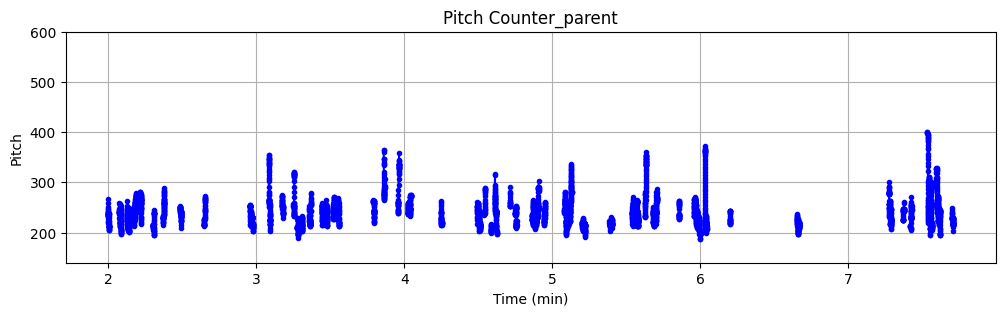

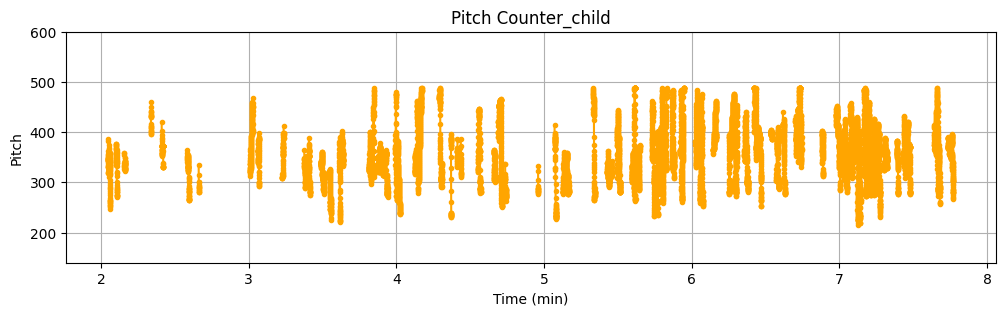

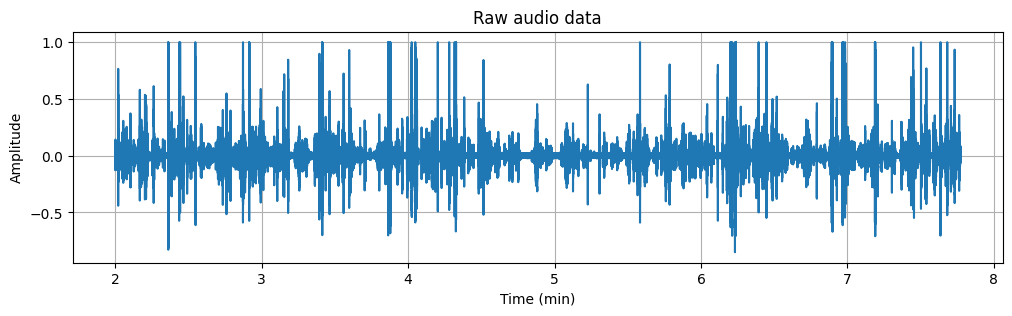

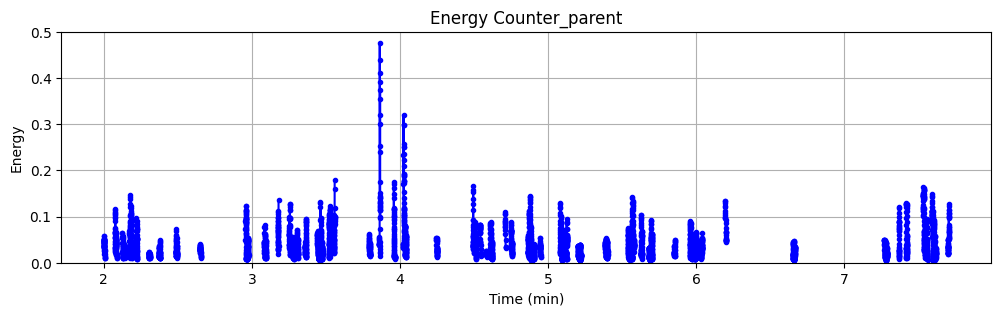

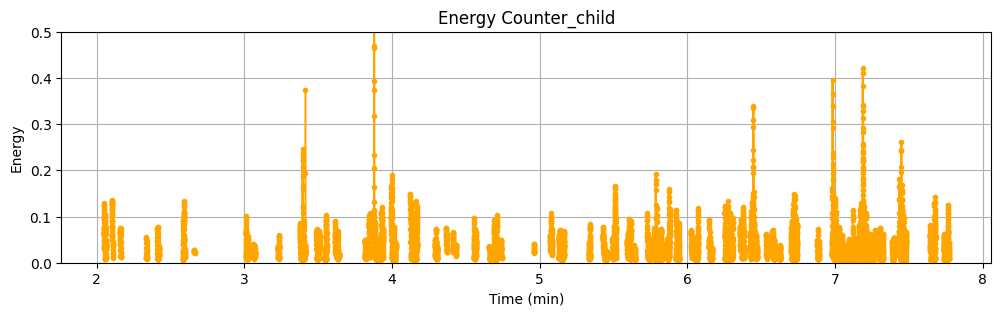

10.707495833333333


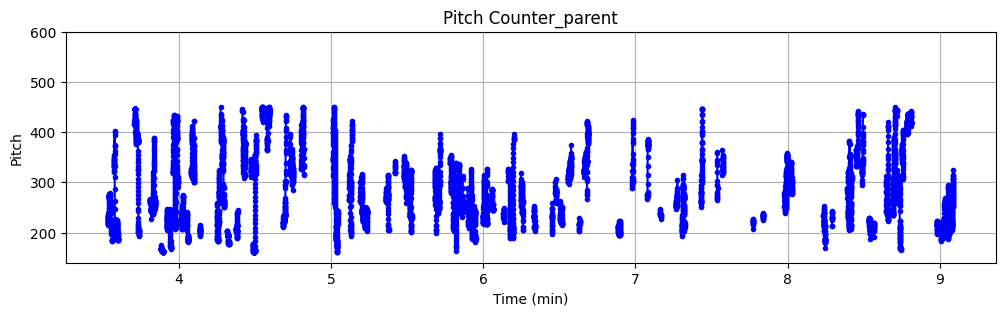

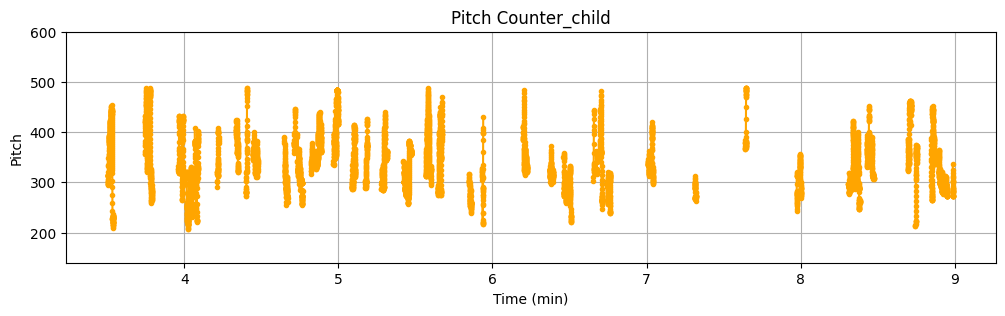

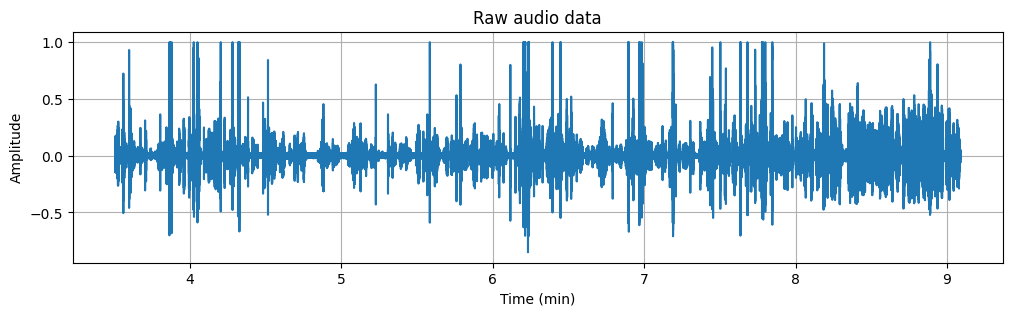

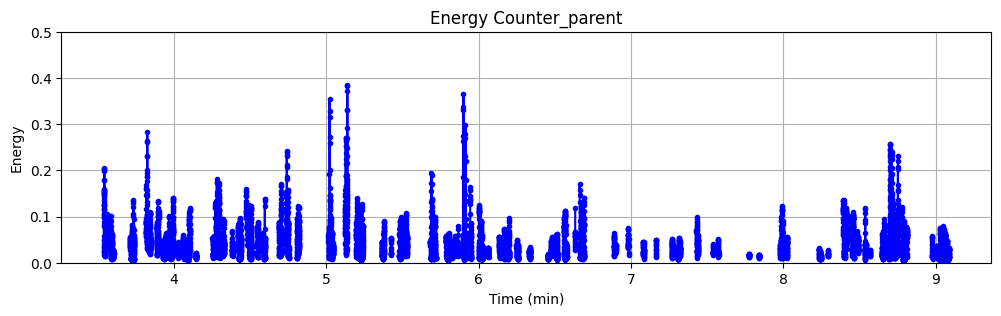

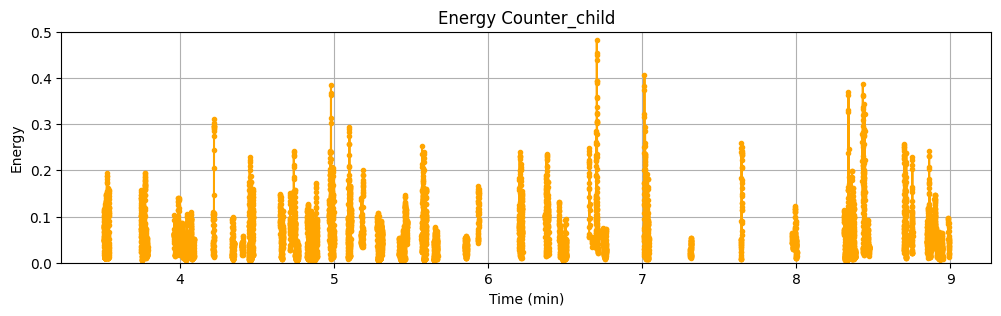

In [18]:
p_time_td,p_pitch_td,c_time_td,c_pitch_td, p_time_e_td,p_energy_td,c_time_e_td,c_energy_td=plotpitch(
    audio_td,sr_td, pitch_p_td, pitch_c_td,folders_td,0)
p_time_asd,p_pitch_asd,c_time_asd,c_pitch_asd, p_time_e_asd,p_energy_asd,c_time_e_asd,c_energy_asd=plotpitch(
    audio_td,sr_asd, pitch_p_asd, pitch_c_asd,folders_asd,0)

In [19]:
def dtw_calculate(p_pitch,c_pitch):
    p_mean = np.nanmean(p_pitch)
    c_mean = np.nanmean(c_pitch)
    # Fill NaN values with the computed mean for each series
    p_pitch_filled = np.where(np.isnan(p_pitch), p_mean, p_pitch)
    c_pitch_filled = np.where(np.isnan(c_pitch), c_mean, c_pitch)
    p_norm = standardize(p_pitch_filled)
    c_norm = standardize(c_pitch_filled)
    idnan_p=np.where(np.round(p_norm)!=0)[0]
    idnan_c=np.where(np.round(c_norm)!=0)[0]
    series1=p_pitch.copy()
    series2=c_pitch.copy()
    valid_idx = ~np.isnan(series1)| ~np.isnan(series2)
    series1,series2= series1[valid_idx],series2[valid_idx]
    series1[np.isnan(series1)]=np.nanmean(series1)
    series2[np.isnan(series2)]=np.nanmean(series2)
    series1_n=standardize(series1)
    series2_n=standardize(series2)    
    # Define a simple distance function for scalar values
    distance_func = lambda a, b: abs(a - b)
    # Compute the fastDTW distance and optimal alignment path using the normalized data
    distance, path = fastdtw(series1_n, series2_n, dist=distance_func)
    print("FastDTW distance (normalized):", distance)
    print("FastDTW distance/length:", distance/(len(idnan_p)+len(idnan_c)))
    print("FastDTW distance/p_len:", distance/len(idnan_p))
    print("FastDTW distance/c_len:", distance/len(idnan_c))
    return distance,distance/(len(idnan_p)+len(idnan_c)),distance/len(idnan_p),distance/len(idnan_c), path,p_norm,c_norm

In [20]:
p_pitch_td_clean=p_pitch_td[np.where(~np.isnan(p_pitch_td))[0]]
c_pitch_td_clean=c_pitch_td[np.where(~np.isnan(c_pitch_td))[0]]
p_pitch_asd_clean=p_pitch_asd[np.where(~np.isnan(p_pitch_asd))[0]]
c_pitch_asd_clean=c_pitch_asd[np.where(~np.isnan(c_pitch_asd))[0]]

In [21]:
p_energy_td_clean=p_energy_td[np.where(~np.isnan(p_energy_td))[0]]
c_energy_td_clean=c_energy_td[np.where(~np.isnan(c_energy_td))[0]]
p_energy_asd_clean=p_energy_asd[np.where(~np.isnan(p_energy_asd))[0]]
c_energy_asd_clean=c_energy_asd[np.where(~np.isnan(c_energy_asd))[0]]

In [22]:
distance_td,distance_td_n,distance_td_p,distance_td_c,path_td,p_norm_td,c_norm_td=dtw_calculate(p_pitch_td,c_pitch_td)
distance_asd,distance_asd_n,distance_asd_p,distance_asd_c,path_asd,p_norm_asd,c_norm_asd=dtw_calculate(p_pitch_asd,c_pitch_asd)

FastDTW distance (normalized): 9119.74888181406
FastDTW distance/length: 0.7092113602779422
FastDTW distance/p_len: 2.0581694610277723
FastDTW distance/c_len: 1.0820774658061294
FastDTW distance (normalized): 7771.498764799815
FastDTW distance/length: 0.5572165171577984
FastDTW distance/p_len: 1.0065404435694618
FastDTW distance/c_len: 1.2482330171538412


In [23]:
distance_td_e,distance_td_n_e,distance_td_p_e,distance_td_c_e,path_td_e,p_norm_td_e,c_norm_td_e=dtw_calculate(p_energy_td,c_energy_td)
distance_asd_e,distance_asd_n_e,distance_asd_p_e,distance_asd_c_e,path_asd_e,p_norm_asd_e,c_norm_asd_e=dtw_calculate(p_energy_asd,c_energy_asd)

FastDTW distance (normalized): 7924.560516901459
FastDTW distance/length: 0.6080847542128192
FastDTW distance/p_len: 1.772832330403011
FastDTW distance/c_len: 0.9255501654872061
FastDTW distance (normalized): 6249.076500194852
FastDTW distance/length: 0.4712727375712558
FastDTW distance/p_len: 0.8948985393376561
FastDTW distance/c_len: 0.9955514577337664


In [24]:
test_p=c_pitch_td[~np.isnan(c_pitch_td)]
test_e=c_energy_td[~np.isnan(c_energy_td)]
print(len(test_p),len(test_e))

10680 10680


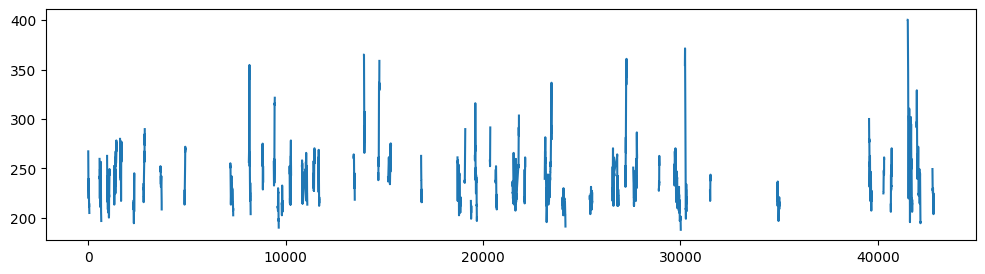

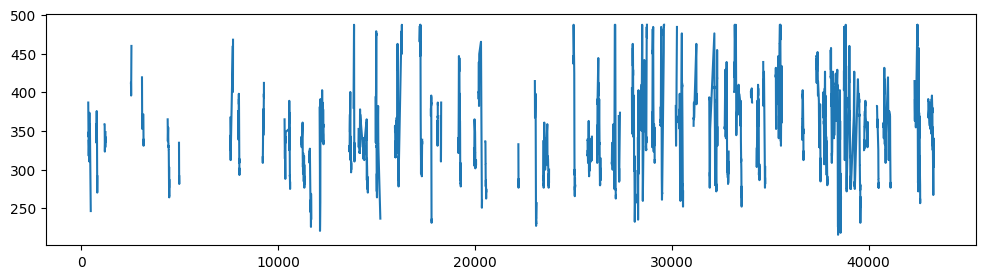

In [25]:
plt.figure(figsize=(12, 3))
plt.plot(p_pitch_td)
#plt.xlim(0,2000)
plt.figure(figsize=(12, 3))
plt.plot(c_pitch_td)
#plt.xlim(0,2000)

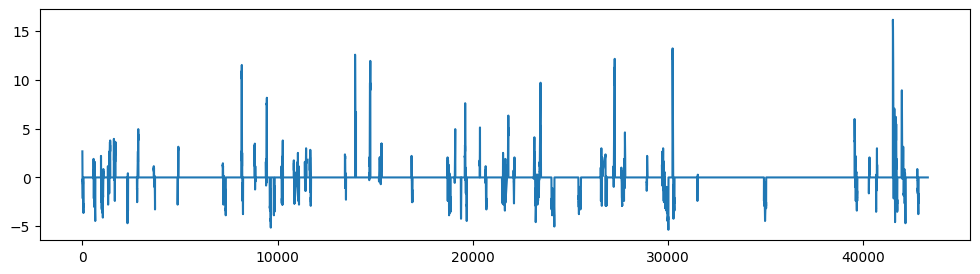

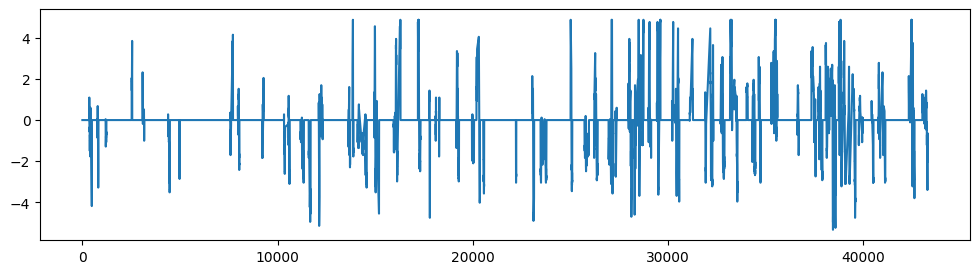

In [26]:
plt.figure(figsize=(12, 3))
plt.plot(p_norm_td)
#plt.xlim(0,2000)
plt.figure(figsize=(12, 3))
plt.plot(c_norm_td)
#plt.xlim(0,2000)

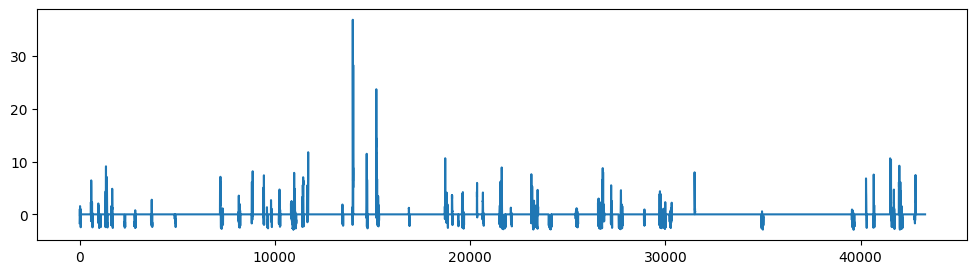

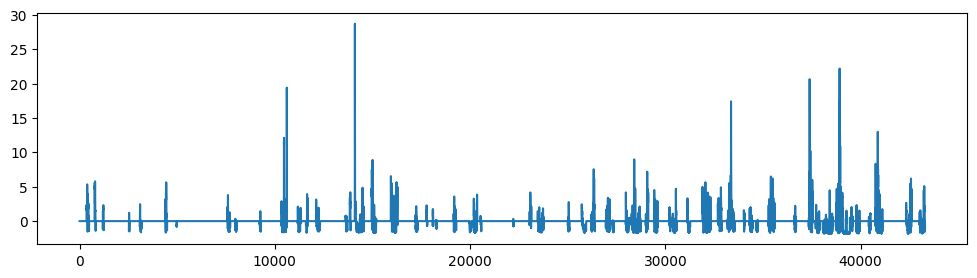

In [27]:
plt.figure(figsize=(12, 3))
plt.plot(p_norm_td_e)
#plt.xlim(0,2000)
plt.figure(figsize=(12, 3))
plt.plot(c_norm_td_e)
#plt.xlim(0,2000)

(0.0, 2000.0)

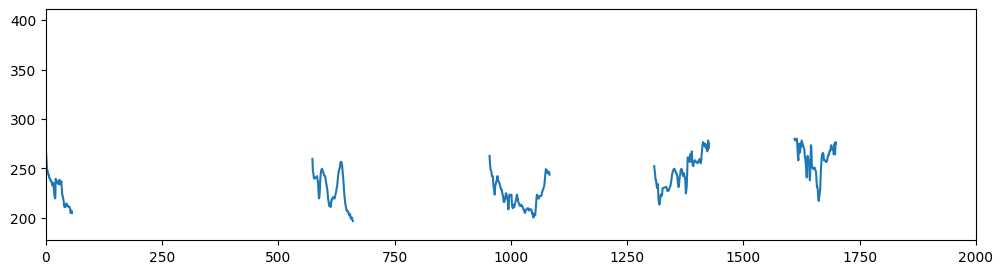

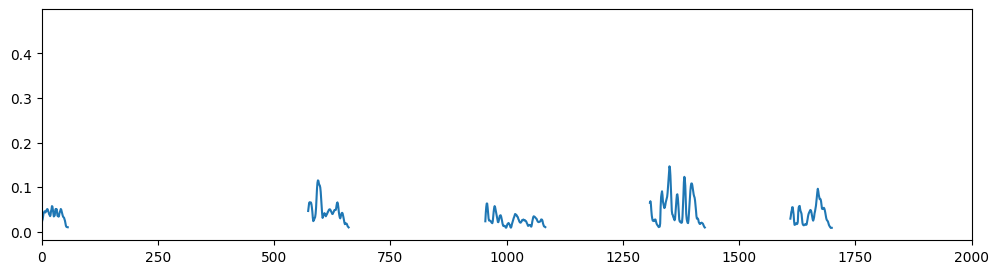

In [28]:
plt.figure(figsize=(12, 3))
plt.plot(p_pitch_td)
plt.xlim(0,2000)
plt.figure(figsize=(12, 3))
plt.plot(p_energy_td)
plt.xlim(0,2000)

In [29]:
def path_plot(pathin,p_pitch,c_pitch,folderin,idin,namein,distancein):
    path=np.array(pathin)
    pause_mask_parent = np.isnan(p_pitch)
    #print(len(np.where(pause_mask_parent==True)[0]))
    pause_mask_child  = np.isnan(c_pitch)
    parent_pauses_on_path = pause_mask_parent[path[:, 0]]
    child_pauses_on_path  = pause_mask_child[path[:, 1]]
    #print(len(np.where(parent_pauses_on_path==True)[0]))
    pause_on_path = parent_pauses_on_path | child_pauses_on_path

    i_indices = path[:, 0]
    j_indices = path[:, 1]
    lags = j_indices - i_indices  # Positive: child leads, Negative: mother leads

    total = len(lags)
    n_child_leads = np.sum(lags > 0)
    n_mother_leads = np.sum(lags < 0)
    n_sync = np.sum(lags == 0)

    prop_mother_leads = n_mother_leads / total
    prop_child_leads = n_child_leads / total
    prop_sync = n_sync / total
    avg_lag = np.mean(lags)
    std_lag = np.std(lags)

    stats = {
        'prop_mother_leads': prop_mother_leads,
        'prop_child_leads': prop_child_leads,
        'prop_synchronous': prop_sync,
        'average_lag': avg_lag,
        'lag_std': std_lag
    }

    print("DTW Leading Role Stats:")
    for k, v in stats.items():
        print(f"{k}: {v:.3f}")
        
    # Now plot the warping path with a diagonal line for reference.
    plt.figure(figsize=(6, 6))
    plt.plot(path[:, 0], path[:, 1],  linestyle='-', label='Alignment Path')

    # Overlay markers where pauses occurred (blue 'x' markers)
    #plt.scatter(path[pause_on_path, 0], path[pause_on_path, 1],
            #color='orange', marker='x', s=5, label='Pauses (filled)')

    # Plot the diagonal line
    max_val = max(path[:, 0].max(), path[:, 1].max())
    plt.plot([0, max_val], [0, max_val], 'r--', label='Diagonal')

    plt.xlabel("Parent pitch index")
    plt.ylabel("Child pitch index")
    plt.title("FastDTW Optimal Alignment Path_"+namein+'_'+str(int(distancein)))
    plt.savefig(pathsave+'/'+'dtw'+namein+folderin[idin],bbox_inches='tight')
    plt.show()

DTW Leading Role Stats:
prop_mother_leads: 0.997
prop_child_leads: 0.000
prop_synchronous: 0.003
average_lag: 3537.714
lag_std: 1932.865


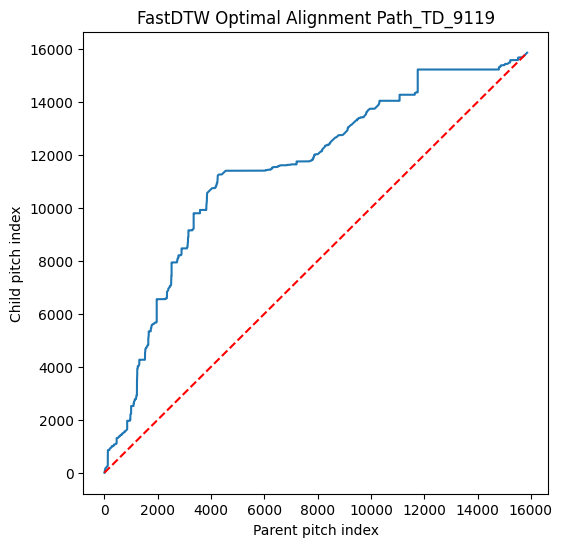

DTW Leading Role Stats:
prop_mother_leads: 0.871
prop_child_leads: 0.128
prop_synchronous: 0.001
average_lag: 896.755
lag_std: 577.696


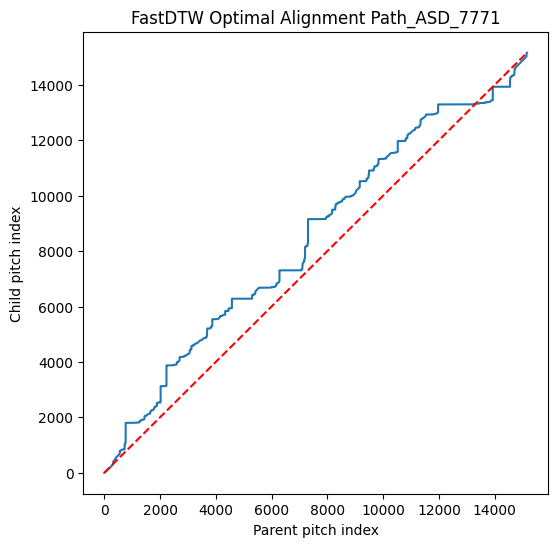

In [30]:
path_plot(path_td,p_pitch_td,c_pitch_td,folders_td,0,'TD',distance_td)
path_plot(path_asd,p_pitch_asd,c_pitch_asd,folders_asd,0,'ASD',distance_asd)

DTW Leading Role Stats:
prop_mother_leads: 0.986
prop_child_leads: 0.011
prop_synchronous: 0.003
average_lag: 3903.610
lag_std: 2169.757


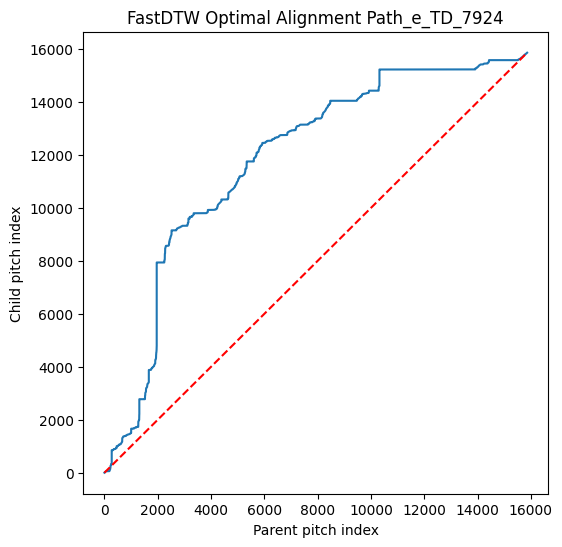

DTW Leading Role Stats:
prop_mother_leads: 0.772
prop_child_leads: 0.223
prop_synchronous: 0.005
average_lag: 406.182
lag_std: 457.352


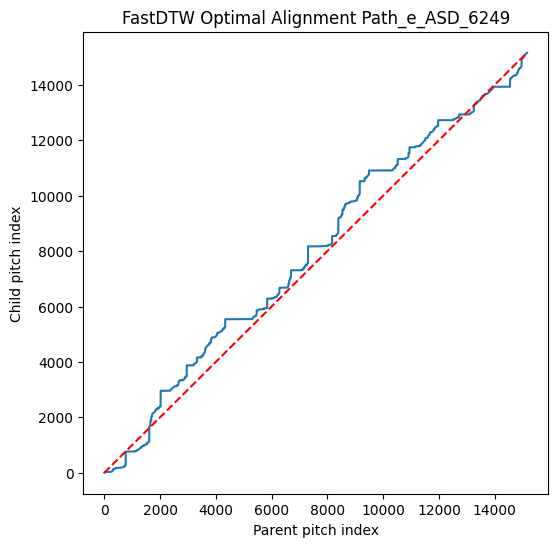

In [31]:
path_plot(path_td_e,p_energy_td,c_energy_td,folders_td,0,'e_TD',distance_td_e)
path_plot(path_asd_e,p_energy_asd,c_energy_asd,folders_asd,0,'e_ASD',distance_asd_e)

In [32]:
def plot_dtw_matching(series1, series2,pathin, offset=4):
    valid_idx = ~np.isnan(series1)| ~np.isnan(series2)
    series1,series2= series1[valid_idx],series2[valid_idx]
    series1[np.isnan(series1)]=np.nanmean(series1)
    series2[np.isnan(series2)]=np.nanmean(series2)
    series1_n=standardize(series1)
    series2_n=standardize(series2)    
    # Create x-axis indices (assumes both series have the same length)
    n1 = len(series1_n)
    x1 = np.arange(n1)
    n2 = len(series2_n)
    x2 = np.arange(n2)    
    # Prepare the plot: plot series1 (shifted upward) and series2
    plt.figure(figsize=(12, 8))
    plt.plot(x1, series1_n + offset, label="Parent (shifted upward)", color="blue")
    plt.plot(x1, series2_n, label="Child", color="green")
    
    # For each matching pair in the warping path, draw a connecting line
    # Each pair (i, j) means that point i in series1 is matched with point j in series2.
    for i, j in pathin:
        if np.round(series1_n[i]) != 0 and np.round(series2_n[j]) != 0:
            plt.plot([i, j], [series1_n[i] + offset, series2_n[j]], color='gray', linewidth=0.5)
    #for i, j in pathin:
        #plt.plot([i, j], [series1[i] + offset, series2[j]], color='gray', linewidth=0.5)
    plt.xlim(0,2000)
    plt.xlabel("Time index")
    plt.ylabel("Standardized Pitch")
    plt.title("DTW Matching between Two Time Series")
    #plt.legend()
    #plt.savefig(save_path, bbox_inches='tight')
    
    plt.show()


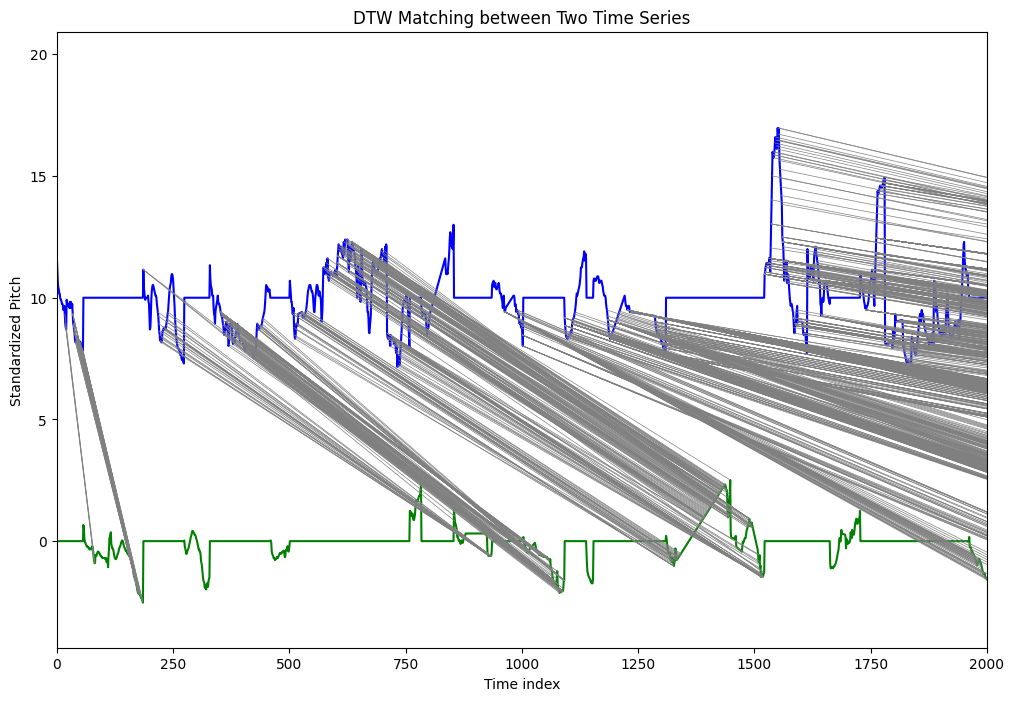

In [33]:
plot_dtw_matching(p_pitch_td, c_pitch_td, np.array(path_td), offset=10)

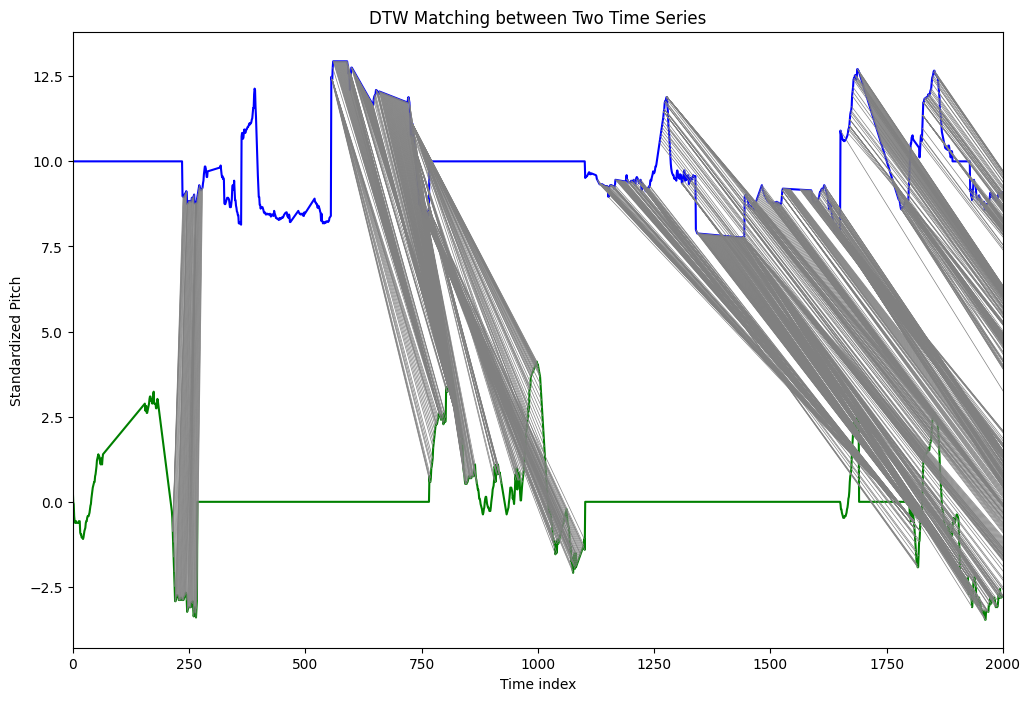

In [34]:
plot_dtw_matching(p_pitch_asd, c_pitch_asd, np.array(path_asd), offset=10)

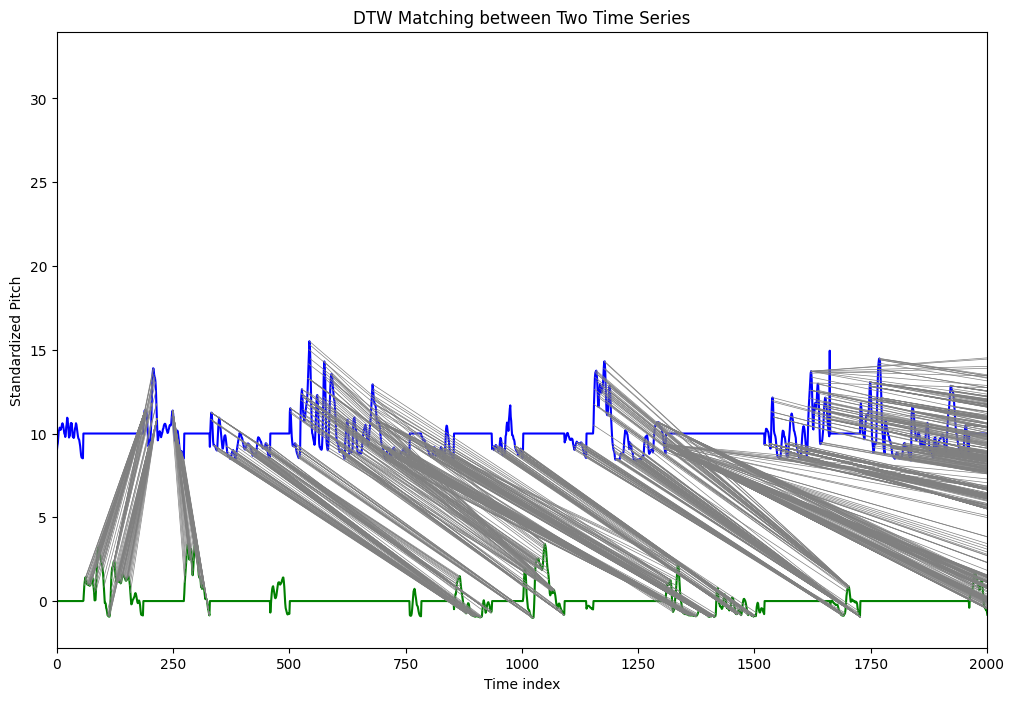

In [35]:
plot_dtw_matching(p_energy_td, c_energy_td, np.array(path_td_e), offset=10)

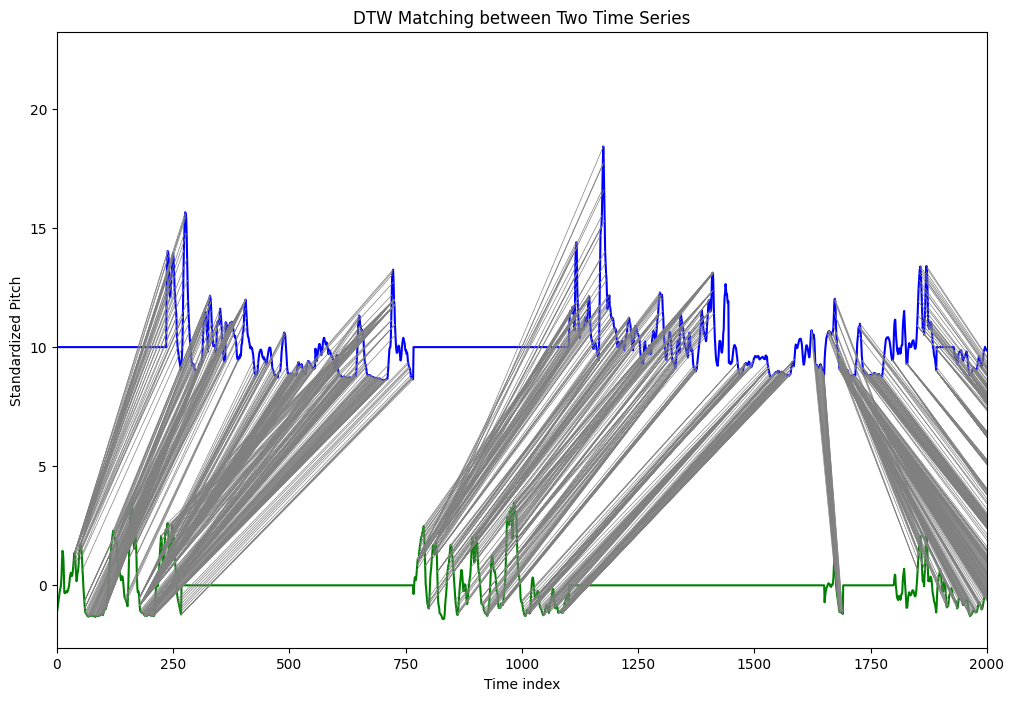

In [36]:
plot_dtw_matching(p_energy_asd, c_energy_asd, np.array(path_asd_e), offset=10)

In [37]:
#tlcc_results = rolling_tlcc(p_norm_asd, c_norm_asd, 50, 10)

In [38]:
#plt.figure(figsize=(12, 6))
#plt.imshow(tlcc_results.T, aspect='auto', cmap='coolwarm', extent=[0, len(tlcc_results), -10, 10],vmin=0,vmax=0.4)
#plt.xlim(0,5000)
#plt.colorbar(label="Cross-Correlation")
#plt.xlabel("Window Index")
#plt.ylabel("Lag (time steps)")
#plt.title("Rolling Window Time-Lagged Cross-Correlation")
#plt.show()

In [39]:
import pycwt as wavelet  # Import the wavelet package
from pycwt.helpers import find
from scipy.ndimage import gaussian_filter

In [40]:
def smooth_wavelet_power(power, scales, sigma=1):
    """
    Custom function to smooth wavelet power using Gaussian filtering.
    
    :param power: Wavelet power spectrum (2D array).
    :param scales: Array of scales.
    :param sigma: Standard deviation for Gaussian smoothing.
    :return: Smoothed power spectrum.
    """
    smoothed = np.copy(power)
    for i in range(len(scales)):
        smoothed[i, :] = gaussian_filter(power[i, :], sigma)
    return smoothed

def cross_wavelet_analysis(series1, series2, dt=1.0):
    """
    Perform Cross-Wavelet Transform (XWT) and Wavelet Coherence (WTC).

    :param series1: First time series (e.g., mother's pitch).
    :param series2: Second time series (e.g., child's pitch).
    :param dt: Sampling period (default=1).
    :return: Wavelet coherence and cross-wavelet results.
    """
    # Remove NaNs (wavelet transform does not support NaNs)
    valid_idx = ~np.isnan(series1)| ~np.isnan(series2)
    series1,series2= series1[valid_idx],series2[valid_idx]
    series1[np.isnan(series1)]=np.nanmean(series1)
    series2[np.isnan(series2)]=np.nanmean(series2)
    series1_n=standardize(series1)
    series2_n=standardize(series2)
    
    # Define the mother wavelet (Morlet)
    mother = wavelet.Morlet(6)

    # Define the smallest scale and number of scales
    s0 = 2 * dt  # Smallest resolvable scale
    dj = 1 / 12  # Frequency scale spacing
    J = int(7 / dj)  # Number of scales

    # Compute Continuous Wavelet Transform (CWT) for both signals
    wave1, scales, freqs, coi, _, _ = wavelet.cwt(series1_n, dt, dj=dj, s0=s0, J=J, wavelet=mother)
    wave2, _, _, _, _, _ = wavelet.cwt(series2_n, dt, dj=dj, s0=s0, J=J, wavelet=mother)

    # Compute Cross-Wavelet Transform (XWT)
    xwt = wave1 * np.conj(wave2)

    # Compute Wavelet Coherence (WTC) using Gaussian Smoothing
    s_wave1 = smooth_wavelet_power(np.abs(wave1) ** 2, scales)
    s_wave2 = smooth_wavelet_power(np.abs(wave2) ** 2, scales)
    s_xwt = smooth_wavelet_power(np.abs(xwt) ** 2, scales)
    coherence = s_xwt / (s_wave1 * s_wave2)  # Normalize coherence

    return coherence, freqs, coi

In [41]:
def analyze_wavelet_coherence(coherence, freqs, time, band1=(0.1, 0.25), band2=(0.25, 0.5), threshold=1, plot=True):
    """
    Analyze cross-wavelet coherence results statistically.

    Parameters:
    - coherence: 2D array (freqs x timepoints), the coherence matrix
    - freqs: 1D array, frequencies corresponding to rows of coherence
    - time: 1D array, timepoints corresponding to columns of coherence
    - band: tuple, frequency range of interest (e.g., (0.1, 0.3) Hz)
    - threshold: float, coherence threshold for high synchrony detection
    - plot: bool, whether to produce summary plots

    Returns:
    - stats: dict containing summary statistics
    """
    stats = {}

    # 1. Global average coherence
    stats['mean_coherence'] = np.nanmean(coherence)

    # 2. Average coherence by frequency
    avg_by_freq = np.nanmean(coherence, axis=1)
    peak_freq = freqs[np.nanargmax(avg_by_freq)]
    stats['peak_coherence_freq'] = peak_freq
    stats['mean_coherence_by_freq'] = avg_by_freq

    # 3. Average coherence by time
    avg_by_time = np.nanmean(coherence, axis=0)
    stats['mean_coherence_by_time'] = avg_by_time

    # 4. Band-limited coherence
    band_mask1 = (freqs >= band1[0]) & (freqs <= band1[1])
    band_coherence1 = coherence[band_mask1, :]
    stats['mean_band_coherence_l'] = np.nanmean(band_coherence1)
    band_mask2 = (freqs >= band2[0]) & (freqs <= band2[1])
    band_coherence2 = coherence[band_mask2, :]
    stats['mean_band_coherence_h'] = np.nanmean(band_coherence2)
    
    # 5. High synchrony detection
    high_sync_mask = coherence > threshold
    stats['prop_coherence_above_threshold'] = np.sum(high_sync_mask) / coherence.size

    # 6. Optional plots
    if plot:
        plt.figure(figsize=(12, 4))
        plt.subplot(1, 2, 1)
        plt.plot(freqs, avg_by_freq)
        plt.axvline(peak_freq, color='red', linestyle='--', label=f'Peak = {peak_freq:.2f} Hz')
        plt.ylim(0.96,1.1)
        plt.xlabel("Frequency (Hz)")
        plt.ylabel("Mean Coherence")
        plt.title("Mean Coherence by Frequency")
        plt.grid(True)
        plt.legend()

        plt.subplot(1, 2, 2)
        plt.plot(time, avg_by_time)
        plt.ylim(0.96,1.1)
        plt.xlabel("Time (s)")
        plt.ylabel("Mean Coherence")
        plt.title("Coherence Over Time")
        plt.grid(True)

        plt.tight_layout()
        plt.show()

        # Optional mask plot
        plt.figure(figsize=(10, 5))
        plt.contourf(time, freqs, high_sync_mask, cmap="Greys", levels=1)
        plt.colorbar()
        plt.xlabel("Time (s)")
        plt.ylabel("Frequency (Hz)")
        plt.title(f"High Synchrony Mask (Coherence > {threshold})")
        plt.tight_layout()
        plt.show()

    return stats

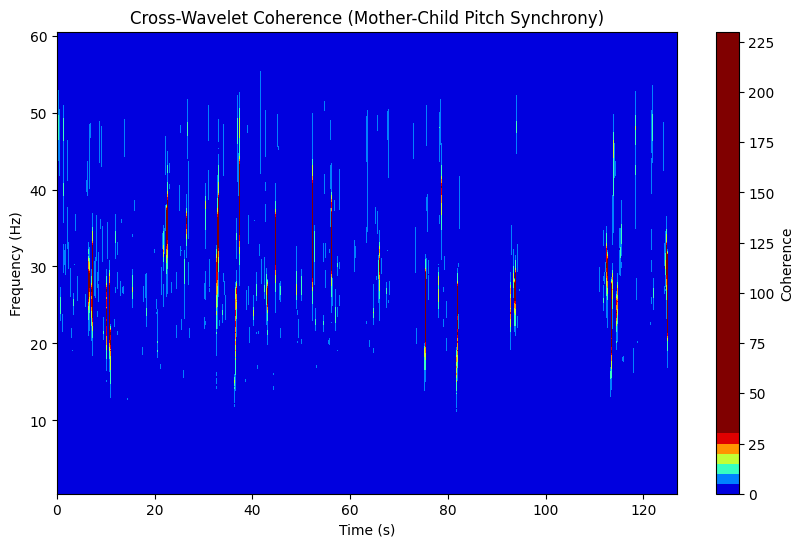

In [42]:
# Compute Cross-Wavelet Transform
coherence_p_td, freqs_p_td, coi_p_td = cross_wavelet_analysis(p_pitch_td, c_pitch_td,dt=1/125)
valid_idx = ~np.isnan(p_pitch_td)| ~np.isnan(c_pitch_td)
p_pitch_td_t= p_pitch_td[valid_idx]
time_p_td=np.arange(len(p_pitch_td_t))
# Plot Wavelet Coherence (Time-Frequency Synchrony)
plt.figure(figsize=(10, 6))
plt.contourf(time_p_td/125, freqs_p_td, coherence_p_td, cmap="jet", levels=50,vmin=0,vmax=30)
#plt.xlim(0,2000)
plt.xlabel("Time (s)")
plt.ylabel("Frequency (Hz)")
plt.title("Cross-Wavelet Coherence (Mother-Child Pitch Synchrony)")

plt.colorbar(label="Coherence")
plt.savefig(pathsave+'/'+'CWT_td_pitch_counter_'+folders_td[0],bbox_inches='tight')
plt.show()

In [ ]:
stats_p_td = analyze_wavelet_coherence(coherence_p_td, freqs_p_td, time_p_td,
                                  band1=(10, 30), band2=(30, 50), threshold=25, plot=True)

# View summary stats
for k, v in stats_p_td.items():
    if isinstance(v, (int, float, np.floating)):
        print(f"{k}: {v:.3f}")

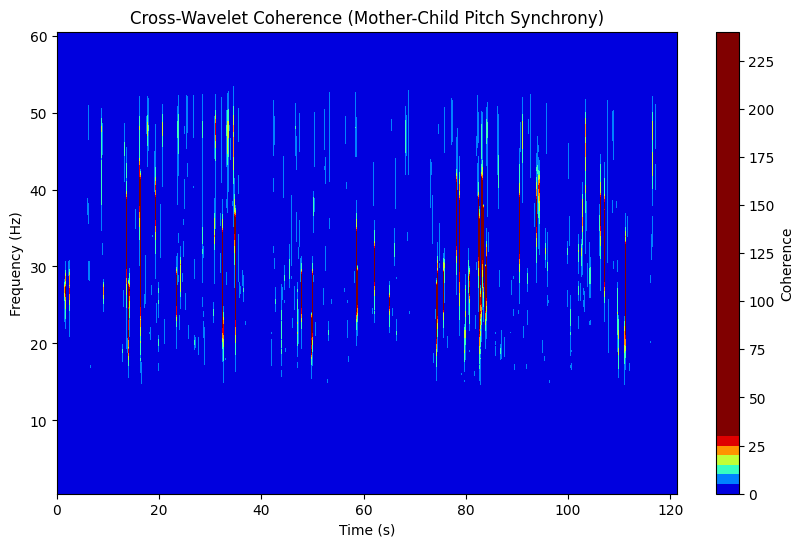

In [43]:
# Compute Cross-Wavelet Transform
coherence_p_asd, freqs_p_asd, coi_p_asd = cross_wavelet_analysis(p_pitch_asd, c_pitch_asd,dt=1/125)
valid_idx = ~np.isnan(p_pitch_asd)| ~np.isnan(c_pitch_asd)
p_pitch_asd_t= p_pitch_asd[valid_idx]
time_p_asd=np.arange(len(p_pitch_asd_t))
# Plot Wavelet Coherence (Time-Frequency Synchrony)
plt.figure(figsize=(10, 6))
plt.contourf(time_p_asd/125, freqs_p_asd, coherence_p_asd, cmap="jet", levels=50,vmin=0,vmax=30)
#plt.xlim(0,2000)
plt.xlabel("Time (s)")
plt.ylabel("Frequency (Hz)")
plt.title("Cross-Wavelet Coherence (Mother-Child Pitch Synchrony)")

plt.colorbar(label="Coherence")
plt.savefig(pathsave+'/'+'CWT_asd_pitch_counter_'+folders_asd[0],bbox_inches='tight')
plt.show()

In [ ]:
stats_p_asd = analyze_wavelet_coherence(coherence_p_asd, freqs_p_asd, time_p_asd,
                                  band1=(10, 30), band2=(30, 50), threshold=25, plot=True)

# View summary stats
for k, v in stats_p_asd.items():
    if isinstance(v, (int, float, np.floating)):
        print(f"{k}: {v:.3f}")

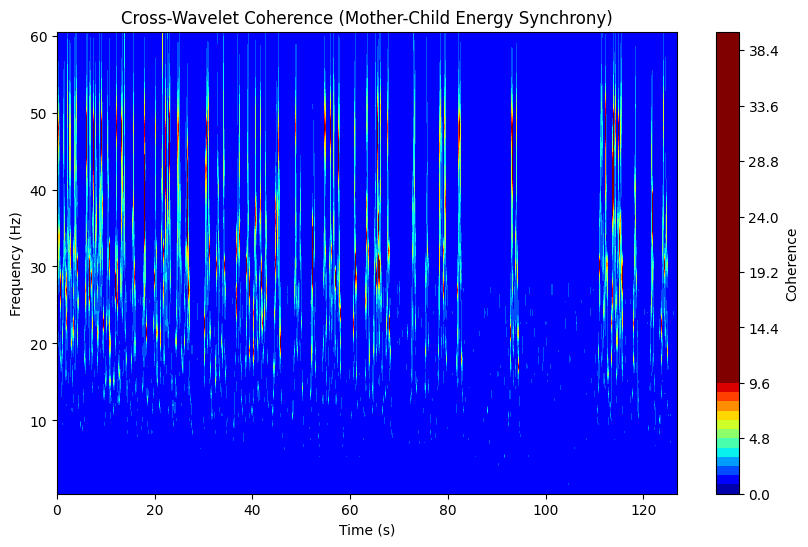

In [44]:
coherence_e_td, freqs_e_td, coi_e_td = cross_wavelet_analysis(p_energy_td, c_energy_td,dt=1/125)
valid_idx = ~np.isnan(p_energy_td)| ~np.isnan(c_energy_td)
p_energy_td_t= p_energy_td[valid_idx]
time_e_td=np.arange(len(p_energy_td_t))
# Plot Wavelet Coherence (Time-Frequency Synchrony)
plt.figure(figsize=(10, 6))
plt.contourf(time_e_td/125, freqs_e_td, coherence_e_td, cmap="jet", levels=50,vmin=0,vmax=10)
#plt.xlim(0,2000)
plt.xlabel("Time (s)")
plt.ylabel("Frequency (Hz)")
plt.title("Cross-Wavelet Coherence (Mother-Child Energy Synchrony)")

plt.colorbar(label="Coherence")
plt.savefig(pathsave+'/'+'CWT_td_energy_counter_'+folders_td[0],bbox_inches='tight')
plt.show()

In [ ]:
stats_e_td = analyze_wavelet_coherence(coherence_e_td, freqs_e_td, time_e_td,
                                  band1=(10, 30), band2=(30, 50), threshold=10, plot=True)

# View summary stats
for k, v in stats_e_td.items():
    if isinstance(v, (int, float, np.floating)):
        print(f"{k}: {v:.3f}")

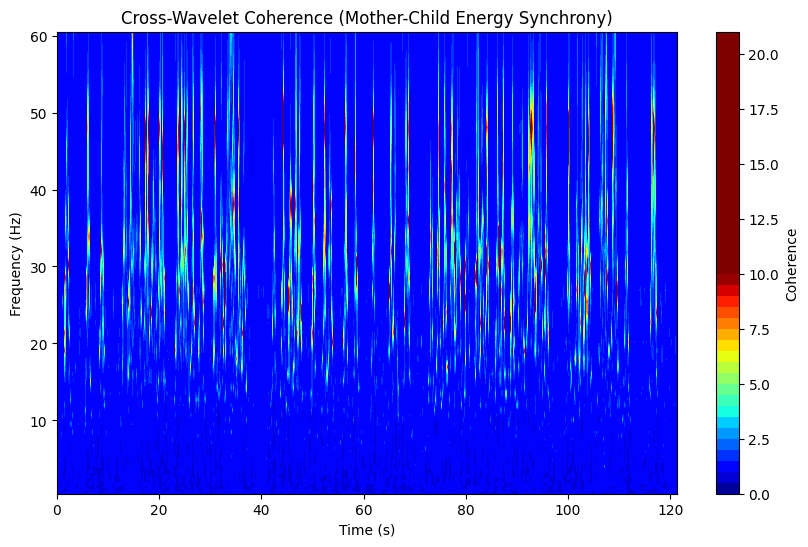

In [45]:
coherence_e_asd, freqs_e_asd, coi_e_asd = cross_wavelet_analysis(p_energy_asd, c_energy_asd,dt=1/125)
valid_idx = ~np.isnan(p_energy_asd)| ~np.isnan(c_energy_asd)
p_energy_asd_t= p_energy_asd[valid_idx]
time_e_asd=np.arange(len(p_energy_asd_t))
# Plot Wavelet Coherence (Time-Frequency Synchrony)
plt.figure(figsize=(10, 6))
plt.contourf(time_e_asd/125, freqs_e_asd, coherence_e_asd, cmap="jet", levels=50,vmin=0,vmax=10)
#plt.xlim(0,2000)
plt.xlabel("Time (s)")
plt.ylabel("Frequency (Hz)")
plt.title("Cross-Wavelet Coherence (Mother-Child Energy Synchrony)")

plt.colorbar(label="Coherence")
plt.savefig(pathsave+'/'+'CWT_asd_energy_counter_'+folders_asd[0],bbox_inches='tight')
plt.show()

In [ ]:
stats_e_asd = analyze_wavelet_coherence(coherence_e_asd, freqs_e_asd, time_e_asd,
                                  band1=(10, 30), band2=(30, 50), threshold=10, plot=True)

# View summary stats
for k, v in stats_e_asd.items():
    if isinstance(v, (int, float, np.floating)):
        print(f"{k}: {v:.3f}")

In [164]:
#def safe_corrcoef(x, y):
    #if np.std(x) == 0 or np.std(y) == 0:
        #return np.nan
    #return np.corrcoef(x, y)[0, 1]
def safe_corrcoef(x, y):
    mask = ~np.isnan(x) & ~np.isnan(y)
    if np.sum(mask) < 5:
        return 0
    return np.corrcoef(x[mask], y[mask])[0, 1]
    
def rolling_tlcc(series1, series2, window_size, max_lag): # rolling window cross-correlation
    # Remove NaNs (wavelet transform does not support NaNs)
    valid_idx = ~np.isnan(series1)| ~np.isnan(series2)
    series1,series2= series1[valid_idx],series2[valid_idx]
    series1[np.isnan(series1)]=np.nanmean(series1)
    series2[np.isnan(series2)]=np.nanmean(series2)
    series1_n=standardize(series1)
    series2_n=standardize(series2)
    series1_n[np.where(np.abs(series1_n) <=0.0000001)[0]] = np.nan
    series2_n[np.where(np.abs(series2_n) <=0.0000001)[0]] = np.nan
    correlations = []
    lags = range(-max_lag, max_lag + 1)
    
    for i in range(len(series1_n) - window_size + 1):
        window1 = series1_n[i:i + window_size]
        window2 = series2_n[i:i + window_size]
        
        # Compute cross-correlation for different lags
        cross_corr = []
        for lag in lags:
            if lag > 0:
                corr = safe_corrcoef(window1[:-lag], window2[lag:])
            elif lag < 0:
                corr = safe_corrcoef(window1[-lag:], window2[:lag])
            else:
                corr = safe_corrcoef(window1, window2)
            cross_corr.append(corr)
        
        correlations.append(cross_corr)
    
    return pd.DataFrame(correlations, columns=lags)

In [245]:
def summarize_tlcc(tlcc_df, exclude_edges=[-50, 50], top_n=5):
    peak_lags = tlcc_df.idxmax(axis=1)
    max_corrs = tlcc_df.max(axis=1)



    # Exclude edge lags for analysis and plotting
    central_lags = peak_lags[~peak_lags.isin(exclude_edges)]
    central_corrs = max_corrs[~max_corrs.isin(exclude_edges)]
    stats = {
        "prop_mother_leads": np.mean(central_lags > 0),
        "prop_child_leads": np.mean(central_lags < 0),
        "prop_synchronous": np.mean(central_lags == 0),
        "avg_peak_lag": central_lags.mean(),
        "std_peak_lag": central_lags.std(),
        "avg_max_corr": central_corrs.mean(),
        "std_max_corr": central_corrs.std()
    }

    print("Rolling TLCC Summary:")
    for k, v in stats.items():
        print(f"{k}: {v:.3f}")

    # Count lag frequencies
    lag_counts = central_lags.value_counts().sort_index()

    # Normalize to proportions
    lag_props = lag_counts / lag_counts.sum()

    # Identify top N lags
    top_lags = lag_props.sort_values(ascending=False).head(top_n).index

    # Assign colors: highlight top lags
    colors = ['orange' if lag in top_lags else 'skyblue' for lag in lag_props.index]

    # Plot normalized histogram (proportions)
    plt.figure(figsize=(8, 4))
    plt.bar(lag_props.index, lag_props.values, color=colors)
    #plt.axvline(x=0, color='red', linestyle='--', label='Synchronous')
    #plt.ylim(0,0.05)
    plt.xlabel("Lag (time steps)")
    plt.ylabel("Proportion of Windows")
    plt.title("Proportional Distribution of Peak Lags (Top 5 Highlighted)")
    plt.legend()
    plt.tight_layout()
    plt.show()

    return stats, peak_lags, max_corrs


In [247]:
def removepause(series1,series2):
   valid_idx = ~np.isnan(series1)| ~np.isnan(series2)
   series1,series2= series1[valid_idx],series2[valid_idx]
   series1[np.isnan(series1)]=np.nanmean(series1)
   series2[np.isnan(series2)]=np.nanmean(series2)
   series1_n=standardize(series1)
   series2_n=standardize(series2)
   return series1_n,series2_n

In [248]:
p_p_n_td,c_p_n_td=removepause(p_pitch_td,c_pitch_td)
p_e_n_td,c_e_n_td=removepause(p_energy_td,c_energy_td)
p_p_n_asd,c_p_n_asd=removepause(p_pitch_asd,c_pitch_asd)
p_e_n_asd,c_e_n_asd=removepause(p_energy_asd,c_energy_asd)

In [249]:
#tlcc_results_td=rolling_tlcc(p_pitch_td,c_pitch_td, 200, 50)
tlcc_results_td=rolling_tlcc(p_p_n_td,c_p_n_td, 200, 50)

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/numpy/lib/function_base.py:2897: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/numpy/lib/function_base.py:2898: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


In [250]:
tlcc_results_td=tlcc_results_td.fillna(0)

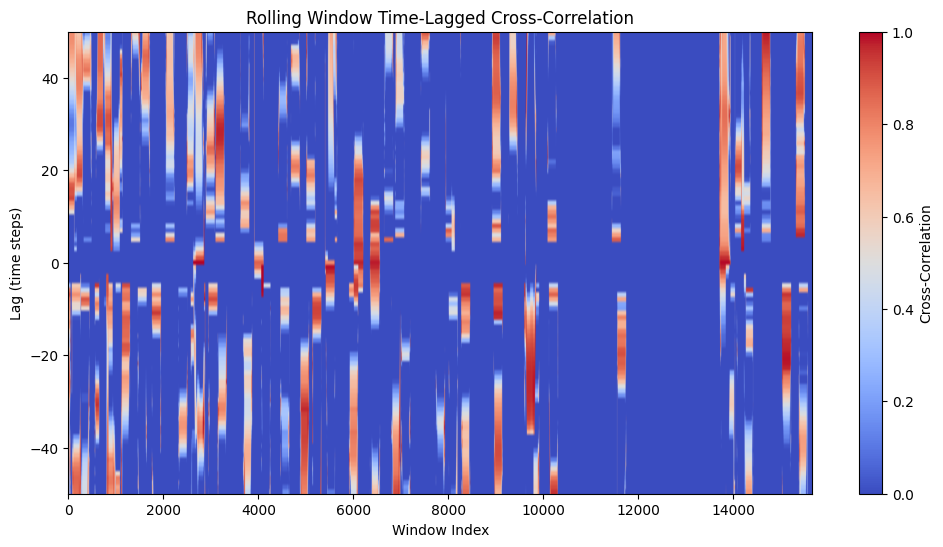

In [251]:
plt.figure(figsize=(12, 6)) #plot the cross-correlation results
plt.imshow(tlcc_results_td.T, aspect='auto', cmap='coolwarm', extent=[0, len(tlcc_results_td), -50, 50],vmin=0,vmax=1)
#plt.imshow(tlcc_results_td.T, aspect='auto', cmap='coolwarm',vmin=0,vmax=0.4)
#plt.xlim(0,2000)
plt.colorbar(label="Cross-Correlation")
plt.xlabel("Window Index")
plt.ylabel("Lag (time steps)")
plt.title("Rolling Window Time-Lagged Cross-Correlation")
plt.savefig(pathsave+'/'+'tlcc_td_p_'+folders_td[0],bbox_inches='tight')
plt.show()

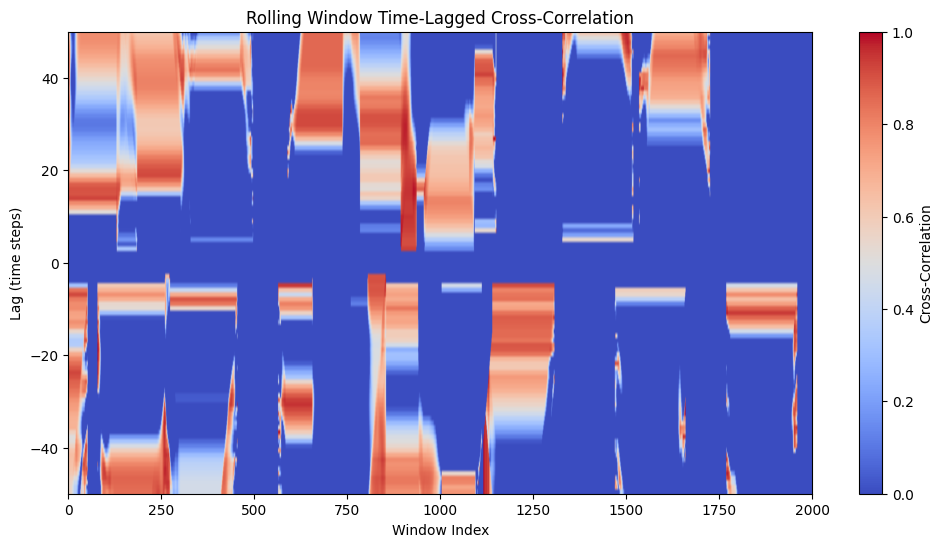

In [252]:
plt.figure(figsize=(12, 6)) #plot the cross-correlation results
plt.imshow(tlcc_results_td.T, aspect='auto', cmap='coolwarm', extent=[0, len(tlcc_results_td), -50, 50],vmin=0,vmax=1)
#plt.imshow(tlcc_results_td.T, aspect='auto', cmap='coolwarm',vmin=0,vmax=0.4)
plt.xlim(0,2000)
plt.colorbar(label="Cross-Correlation")
plt.xlabel("Window Index")
plt.ylabel("Lag (time steps)")
plt.title("Rolling Window Time-Lagged Cross-Correlation")
plt.savefig(pathsave+'/'+'tlcc_td_p_2000_'+folders_td[0],bbox_inches='tight')
plt.show()

In [253]:
tlcc_results_asd=rolling_tlcc(p_pitch_asd,c_pitch_asd, 1000, 50)
tlcc_results_asd=tlcc_results_asd.fillna(0)

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/numpy/lib/function_base.py:2897: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/numpy/lib/function_base.py:2898: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


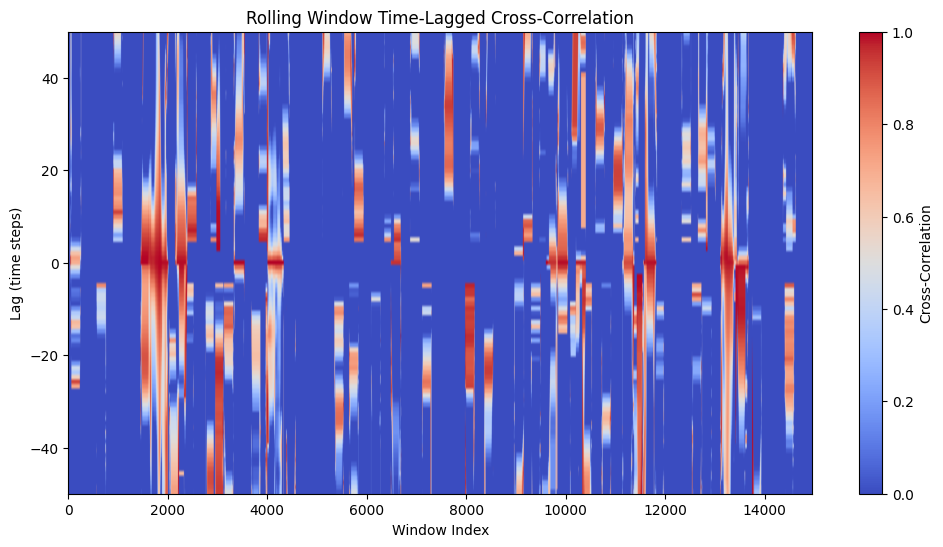

In [242]:

plt.figure(figsize=(12, 6)) #plot the cross-correlation results
plt.imshow(tlcc_results_asd.T, aspect='auto', cmap='coolwarm', extent=[0, len(tlcc_results_asd), -50, 50],vmin=0,vmax=1)
#plt.xlim(0,2000)
plt.colorbar(label="Cross-Correlation")
plt.xlabel("Window Index")
plt.ylabel("Lag (time steps)")
plt.title("Rolling Window Time-Lagged Cross-Correlation")
plt.savefig(pathsave+'/'+'tlcc_asd_p_'+folders_asd[0],bbox_inches='tight')
plt.show()

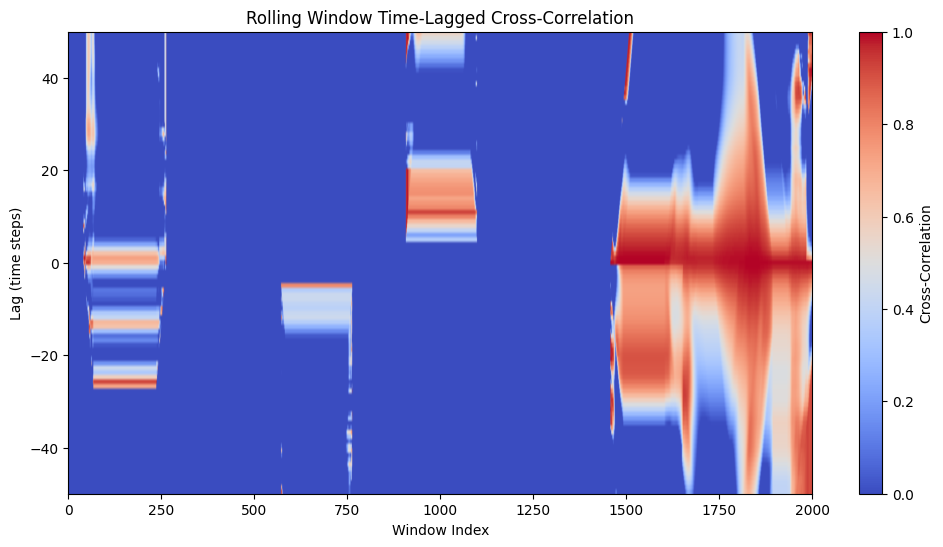

In [243]:
plt.figure(figsize=(12, 6)) #plot the cross-correlation results
plt.imshow(tlcc_results_asd.T, aspect='auto', cmap='coolwarm', extent=[0, len(tlcc_results_asd), -50, 50],vmin=0,vmax=1)
plt.xlim(0,2000)
plt.colorbar(label="Cross-Correlation")
plt.xlabel("Window Index")
plt.ylabel("Lag (time steps)")
plt.title("Rolling Window Time-Lagged Cross-Correlation")
plt.savefig(pathsave+'/'+'tlcc_asd_p_2000_'+folders_asd[0],bbox_inches='tight')
plt.show()

Rolling TLCC Summary:
prop_mother_leads: 0.488
prop_child_leads: 0.393
prop_synchronous: 0.119
avg_peak_lag: 2.284
std_peak_lag: 22.443
avg_max_corr: 0.514
std_max_corr: 0.440


/var/folders/4x/h2wglmj916z6lk1y4ln55h0h0000gn/T/ipykernel_18570/667059274.py:44: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


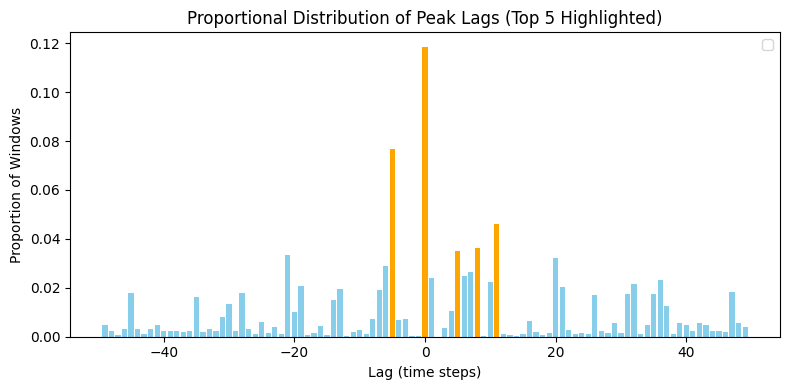

Rolling TLCC Summary:
prop_mother_leads: 0.379
prop_child_leads: 0.377
prop_synchronous: 0.244
avg_peak_lag: -0.696
std_peak_lag: 19.727
avg_max_corr: 0.584
std_max_corr: 0.422


/var/folders/4x/h2wglmj916z6lk1y4ln55h0h0000gn/T/ipykernel_18570/667059274.py:44: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


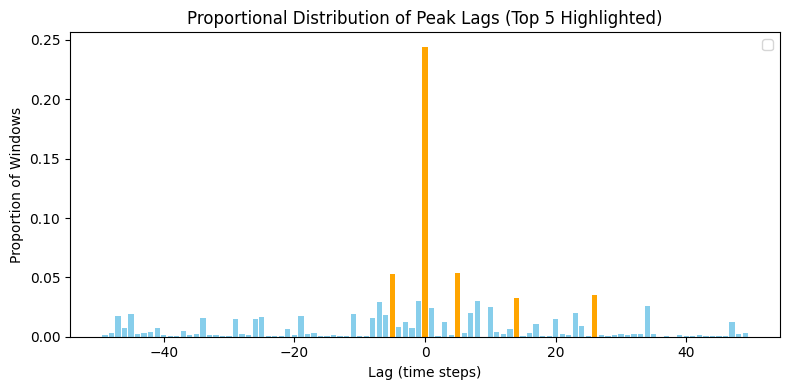

In [254]:
stats_td, peak_lags_td, max_corrs_td = summarize_tlcc(tlcc_results_td)
stats_asd, peak_lags_asd, max_corrs_asd = summarize_tlcc(tlcc_results_asd)

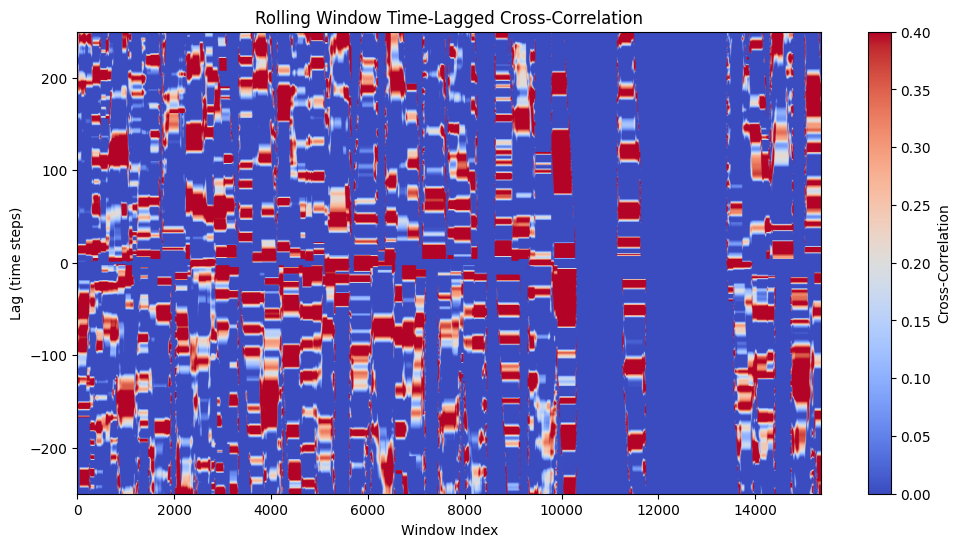

In [176]:
tlcc_results_td_e=rolling_tlcc(p_energy_td,c_energy_td, 500, 250)
tlcc_results_td_e=tlcc_results_td_e.fillna(0)

plt.figure(figsize=(12, 6)) #plot the cross-correlation results
plt.imshow(tlcc_results_td_e.T, aspect='auto', cmap='coolwarm', extent=[0, len(tlcc_results_td_e), -250, 250],vmin=0,vmax=0.4)
plt.colorbar(label="Cross-Correlation")
plt.xlabel("Window Index")
plt.ylabel("Lag (time steps)")
plt.title("Rolling Window Time-Lagged Cross-Correlation")
plt.savefig(pathsave+'/'+'tlcc_td_e_'+folders_td[0],bbox_inches='tight')
plt.show()

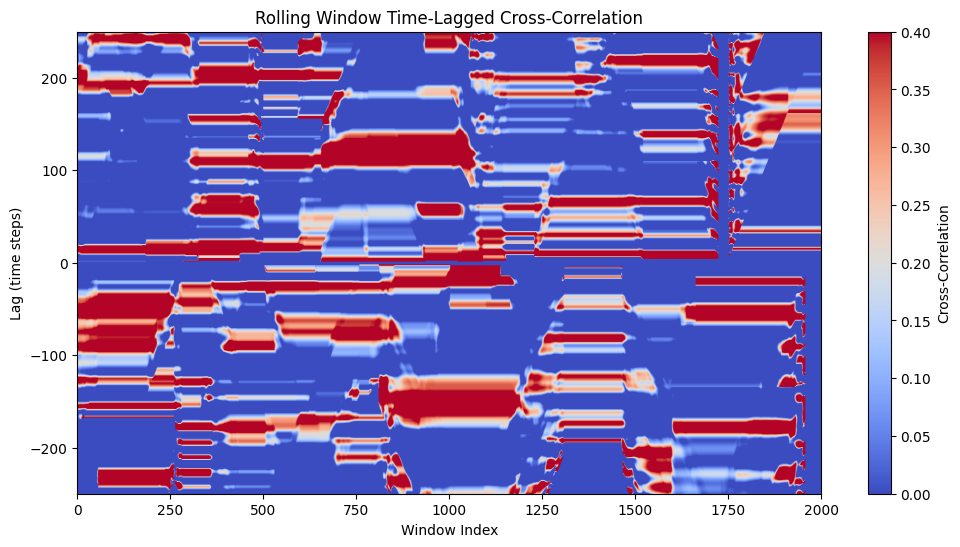

In [177]:
plt.figure(figsize=(12, 6)) #plot the cross-correlation results
plt.imshow(tlcc_results_td_e.T, aspect='auto', cmap='coolwarm', extent=[0, len(tlcc_results_td_e), -250, 250],vmin=0,vmax=0.4)
plt.xlim(0,2000)
plt.colorbar(label="Cross-Correlation")
plt.xlabel("Window Index")
plt.ylabel("Lag (time steps)")
plt.title("Rolling Window Time-Lagged Cross-Correlation")
plt.savefig(pathsave+'/'+'tlcc_td_e_2000_'+folders_td[0],bbox_inches='tight')
plt.show()

In [178]:
tlcc_results_asd_e=rolling_tlcc(p_energy_asd,c_energy_asd, 500, 250)
tlcc_results_asd_e=tlcc_results_asd_e.fillna(0)

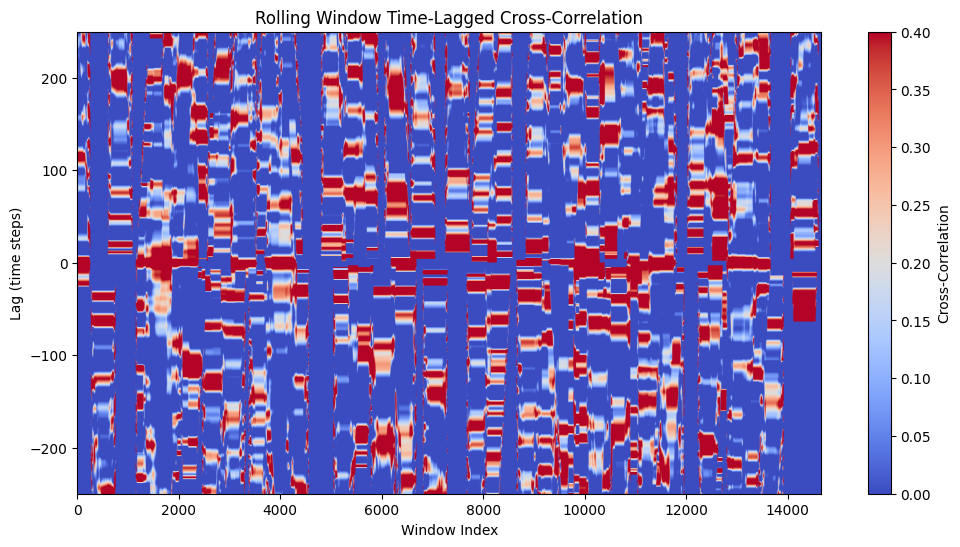

In [179]:
plt.figure(figsize=(12, 6)) #plot the cross-correlation results
plt.imshow(tlcc_results_asd_e.T, aspect='auto', cmap='coolwarm', extent=[0, len(tlcc_results_asd_e), -250, 250],vmin=0,vmax=0.4)
plt.colorbar(label="Cross-Correlation")
plt.xlabel("Window Index")
plt.ylabel("Lag (time steps)")
plt.title("Rolling Window Time-Lagged Cross-Correlation")
plt.savefig(pathsave+'/'+'tlcc_asd_e_'+folders_asd[0],bbox_inches='tight')
plt.show()

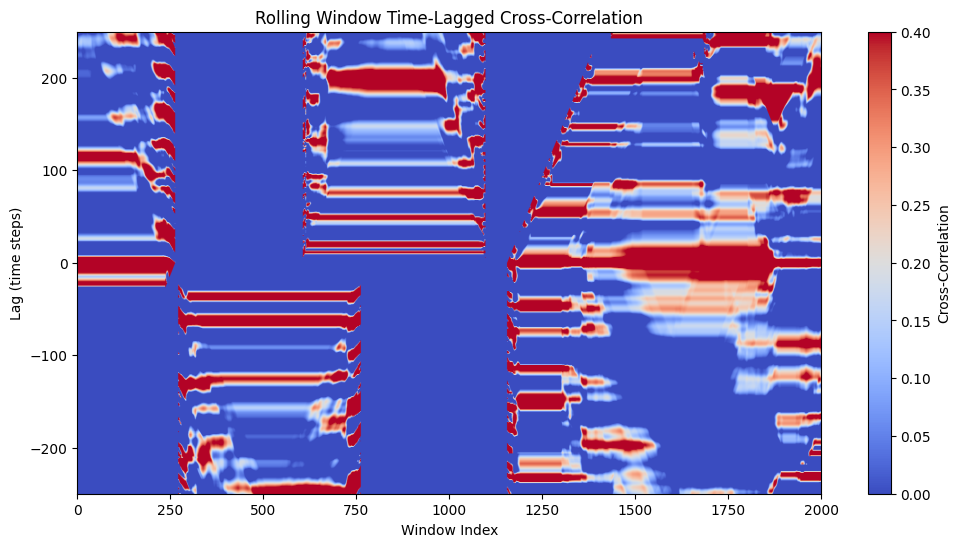

In [180]:
plt.figure(figsize=(12, 6)) #plot the cross-correlation results
plt.imshow(tlcc_results_asd_e.T, aspect='auto', cmap='coolwarm', extent=[0, len(tlcc_results_asd_e), -250, 250],vmin=0,vmax=0.4)
plt.xlim(0,2000)
plt.colorbar(label="Cross-Correlation")
plt.xlabel("Window Index")
plt.ylabel("Lag (time steps)")
plt.title("Rolling Window Time-Lagged Cross-Correlation")
plt.savefig(pathsave+'/'+'tlcc_asd_e_2000_'+folders_asd[0],bbox_inches='tight')
plt.show()

Rolling TLCC Summary:
prop_mother_leads: 0.303
prop_child_leads: 0.576
prop_synchronous: 0.121
avg_peak_lag: -54.203
std_peak_lag: 132.587
avg_max_corr: 0.771
std_max_corr: 0.359


/var/folders/4x/h2wglmj916z6lk1y4ln55h0h0000gn/T/ipykernel_18570/861242932.py:42: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


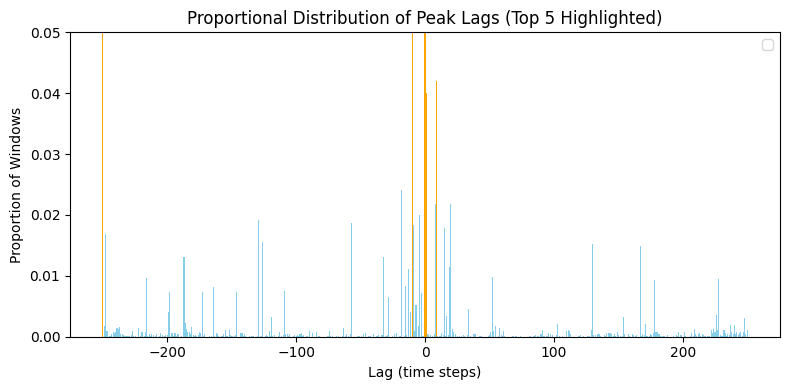

/var/folders/4x/h2wglmj916z6lk1y4ln55h0h0000gn/T/ipykernel_18570/861242932.py:42: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


Rolling TLCC Summary:
prop_mother_leads: 0.300
prop_child_leads: 0.337
prop_synchronous: 0.362
avg_peak_lag: -13.730
std_peak_lag: 81.283
avg_max_corr: 0.905
std_max_corr: 0.208


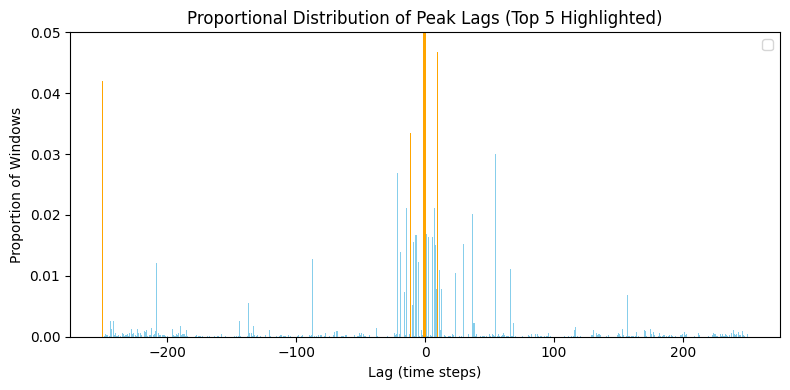

In [181]:
stats_td_e, peak_lags_td_e, max_corrs_td_e = summarize_tlcc(tlcc_results_td_e)
stats_asd_e, peak_lags_asd_e, max_corrs_asd_e = summarize_tlcc(tlcc_results_asd_e)

In [327]:
def compute_mutual_information(series1, series2, num_bins=5): #mutual information
    """
    Compute the mutual information between two time series.
    
    :param series1: First time series (e.g., mother's pitch).
    :param series2: Second time series (e.g., child's pitch).
    :param num_bins: Number of bins for discretization.
    :return: Mutual information score.
    """
    valid_idx = ~np.isnan(series1) & ~np.isnan(series2)
    series1, series2 = series1[valid_idx], series2[valid_idx]

    # Reshape for sklearn function
    series1_n = series1.reshape(-1, 1)
    series2_n = series2.reshape(-1, 1)

    # Compute Mutual Information
    if len(series1_n)>200 and len(series2_n)>200:
        mi_score = mutual_info_regression(series1_n, series2_n, discrete_features=False, n_neighbors=num_bins)
    else:
        mi_score=[0]
    
    return mi_score[0]  # MI value

In [328]:
def time_lagged_mutual_information(series1, series2, max_lag=10, num_bins=5): # time lag mutual information
    """
    Compute mutual information at different time lags.
    
    :param series1: First time series (e.g., mother's pitch).
    :param series2: Second time series (e.g., child's pitch).
    :param max_lag: Maximum lag to consider.
    :return: Array of mutual information values for each lag.
    """ 
    mi_scores = []
    lags = np.arange(-max_lag, max_lag + 1)

    for lag in lags:
        if lag > 0:
            mi = compute_mutual_information(series1[:-lag], series2[lag:], num_bins)
        elif lag < 0:
            mi = compute_mutual_information(series1[-lag:], series2[:lag], num_bins)
        else:
            mi = compute_mutual_information(series1, series2, num_bins)
        mi_scores.append(mi)

    return lags, np.array(mi_scores)

In [257]:
def removepause(series1,series2):
   valid_idx = ~np.isnan(series1)| ~np.isnan(series2)
   series1,series2= series1[valid_idx],series2[valid_idx]
   series1[np.isnan(series1)]=np.nanmean(series1)
   series2[np.isnan(series2)]=np.nanmean(series2)
   series1_n=standardize(series1)
   series2_n=standardize(series2)
   return series1_n,series2_n

In [258]:
p_p_n_td,c_p_n_td=removepause(p_pitch_td,c_pitch_td)
p_e_n_td,c_e_n_td=removepause(p_energy_td,c_energy_td)
p_p_n_asd,c_p_n_asd=removepause(p_pitch_asd,c_pitch_asd)
p_e_n_asd,c_e_n_asd=removepause(p_energy_asd,c_energy_asd)

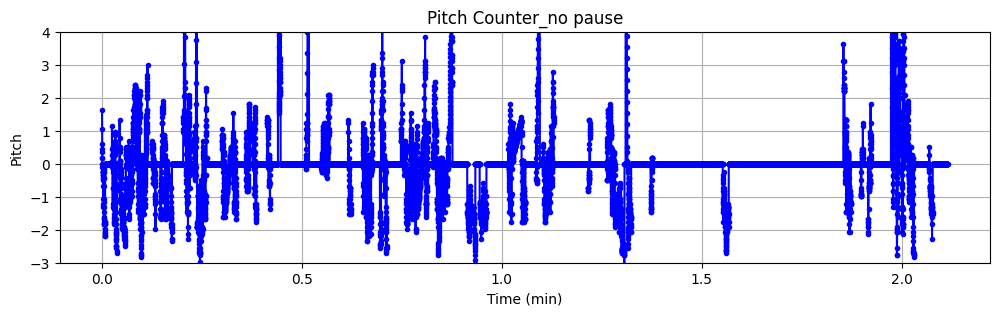

In [259]:
plt.figure(figsize=(12, 3))
plt.plot(np.arange(len(p_p_n_td))/125/60, p_p_n_td, c='blue',marker='o', linestyle='-', markersize=3)
#plt.xlim(np.min(p_time/60),np.max(p_time/60))
plt.ylim(-3,4)
plt.xlabel('Time (min)')
plt.ylabel('Pitch')
plt.title('Pitch Counter_no pause')
plt.grid(True)
plt.savefig(pathsave+'/'+'parent_p_nop'+folders_td[0],bbox_inches='tight')
plt.show()

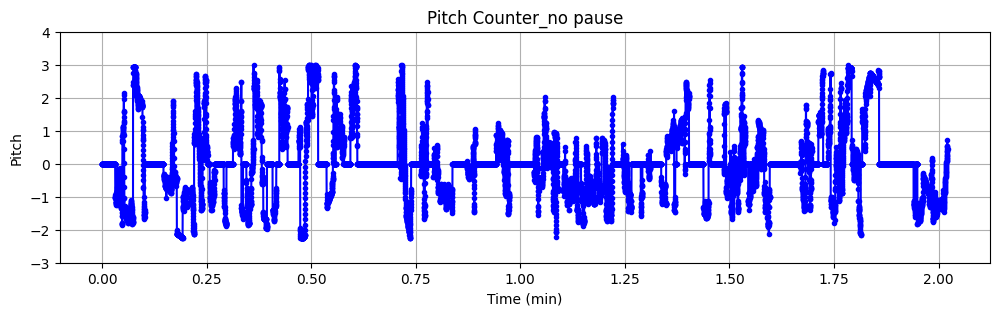

In [260]:
plt.figure(figsize=(12, 3))
plt.plot(np.arange(len(p_p_n_asd))/125/60, p_p_n_asd, c='blue',marker='o', linestyle='-', markersize=3)
#plt.xlim(np.min(p_time/60),np.max(p_time/60))
plt.ylim(-3,4)
plt.xlabel('Time (min)')
plt.ylabel('Pitch')
plt.title('Pitch Counter_no pause')
plt.grid(True)
plt.savefig(pathsave+'/'+'parent_p_nop'+folders_asd[0],bbox_inches='tight')
plt.show()

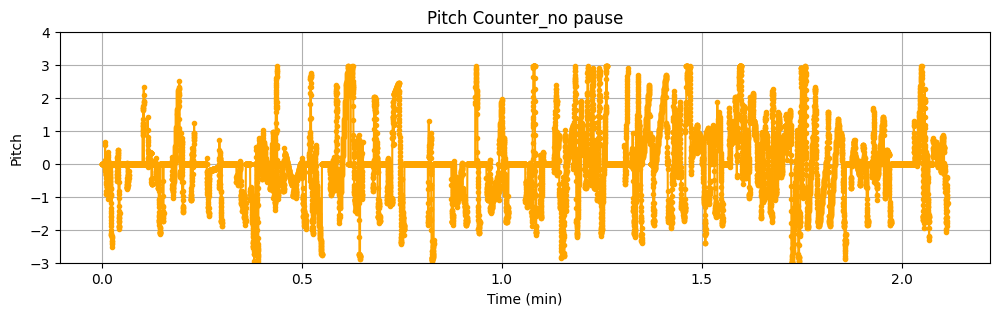

In [261]:
plt.figure(figsize=(12, 3))
plt.plot(np.arange(len(c_p_n_td))/125/60, c_p_n_td, c='orange',marker='o', linestyle='-', markersize=3)
plt.ylim(-3,4)
plt.xlabel('Time (min)')
plt.ylabel('Pitch')
plt.title('Pitch Counter_no pause')
plt.grid(True)
plt.savefig(pathsave+'/'+'child_p_nop'+folders_td[0],bbox_inches='tight')
plt.show()

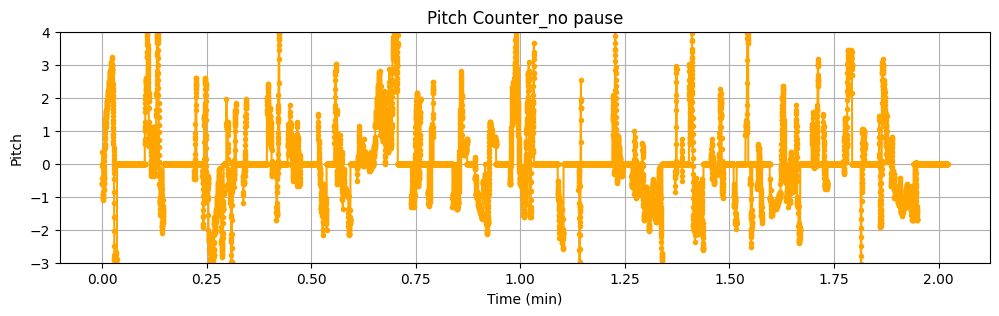

In [262]:
plt.figure(figsize=(12, 3))
plt.plot(np.arange(len(c_p_n_asd))/125/60, c_p_n_asd, c='orange',marker='o', linestyle='-', markersize=3)
plt.ylim(-3,4)
plt.xlabel('Time (min)')
plt.ylabel('Pitch')
plt.title('Pitch Counter_no pause')
plt.grid(True)
plt.savefig(pathsave+'/'+'child_p_nop'+folders_asd[0],bbox_inches='tight')
plt.show()

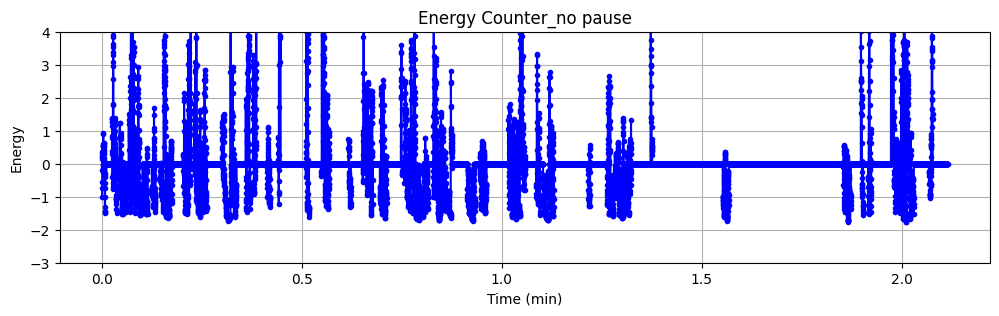

In [263]:
plt.figure(figsize=(12, 3))
plt.plot(np.arange(len(p_e_n_td))/125/60, p_e_n_td, c='blue',marker='o', linestyle='-', markersize=3)
plt.ylim(-3,4)
plt.xlabel('Time (min)')
plt.ylabel('Energy')
plt.title('Energy Counter_no pause')
plt.grid(True)
plt.savefig(pathsave+'/'+'parent_e_nop'+folders_td[0],bbox_inches='tight')
plt.show()

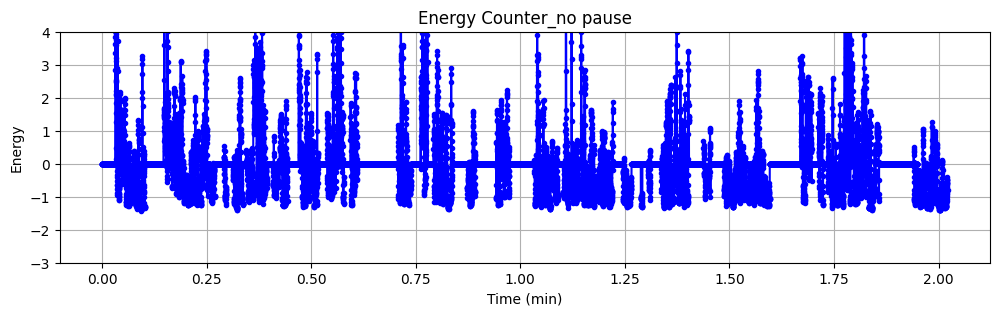

In [264]:
plt.figure(figsize=(12, 3))
plt.plot(np.arange(len(p_e_n_asd))/125/60, p_e_n_asd, c='blue',marker='o', linestyle='-', markersize=3)
plt.ylim(-3,4)
plt.xlabel('Time (min)')
plt.ylabel('Energy')
plt.title('Energy Counter_no pause')
plt.grid(True)
plt.savefig(pathsave+'/'+'parent_e_nop'+folders_asd[0],bbox_inches='tight')
plt.show()

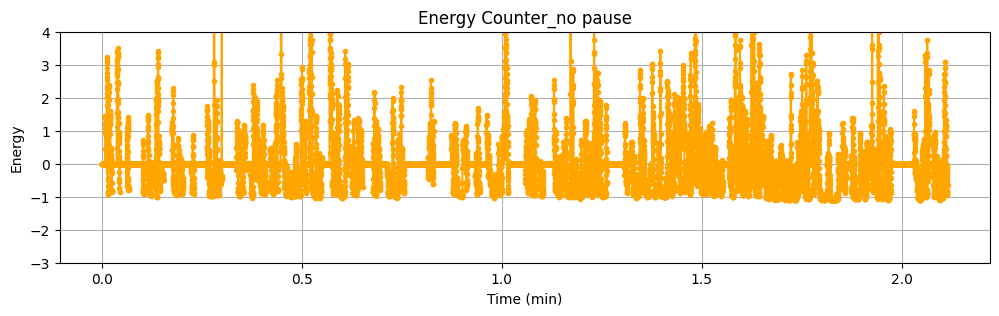

In [265]:
plt.figure(figsize=(12, 3))
plt.plot(np.arange(len(c_e_n_td))/125/60, c_e_n_td, c='orange',marker='o', linestyle='-', markersize=3)
plt.ylim(-3,4)
plt.xlabel('Time (min)')
plt.ylabel('Energy')
plt.title('Energy Counter_no pause')
plt.grid(True)
plt.savefig(pathsave+'/'+'child_e_nop'+folders_td[0],bbox_inches='tight')
plt.show()

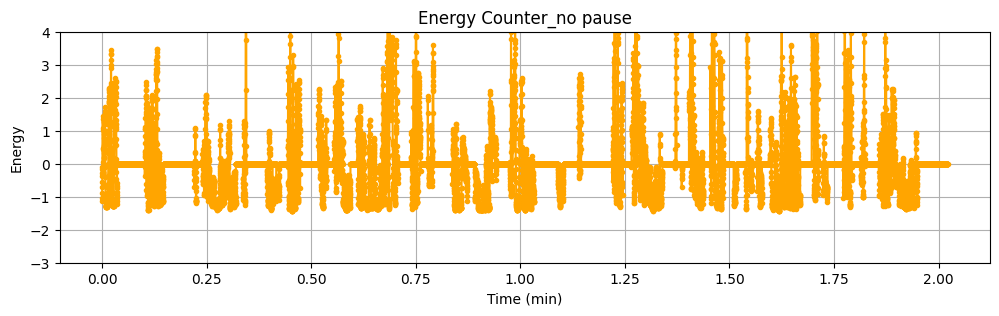

In [266]:
plt.figure(figsize=(12, 3))
plt.plot(np.arange(len(c_e_n_asd))/125/60, c_e_n_asd, c='orange',marker='o', linestyle='-', markersize=3)
plt.ylim(-3,4)
plt.xlabel('Time (min)')
plt.ylabel('Energy')
plt.title('Energy Counter_no pause')
plt.grid(True)
plt.savefig(pathsave+'/'+'child_e_nop'+folders_asd[0],bbox_inches='tight')
plt.show()

In [291]:
def renan(series1in,series2in):
    s_p_td_out=series1in.copy()
    s_c_td_out=series2in.copy()
    s_p_td_out[np.where(np.abs(series1in)<0.0000001)[0]] = np.nan
    s_c_td_out[np.where(np.abs(series2in)<0.0000001)[0]] = np.nan 
    return s_p_td_out,s_c_td_out

In [320]:
s_p_td,s_c_td=renan(p_p_n_td,c_p_n_td)
s_p_asd,s_c_asd=renan(p_p_n_asd,c_p_n_asd)
s_p_td_e,s_c_td_e=renan(p_e_n_td,c_e_n_td)
s_p_asd_e,s_c_asd_e=renan(p_e_n_asd,c_e_n_asd)

In [317]:
import warnings
warnings.filterwarnings("ignore")

In [322]:
from scipy.signal import find_peaks

def summarize_tlmi(lags, mi_lagged, lag_step_ms=None, peak_prominence=0.01, plot=True):
    """
    Summarize and visualize time-lagged mutual information (TLMI), including top 3 peaks.

    Parameters:
    - lags: Array of lag values (e.g., in time steps)
    - mi_lagged: Mutual information values at each lag
    - lag_step_ms: Optional, time step in milliseconds (to convert lags to ms)
    - peak_prominence: Minimum prominence to count local peaks
    - plot: Whether to display the TLMI plot

    Returns:
    - stats: Dictionary of summary statistics including top 3 peaks
    """
    stats = {}

    # Basic stats
    stats['mean_mi'] = np.mean(mi_lagged)
    stats['std_mi'] = np.std(mi_lagged)

    # Find all peaks
    peaks, _ = find_peaks(mi_lagged, prominence=peak_prominence)
    peak_vals = mi_lagged[peaks]
    peak_lags = lags[peaks]

    # Sort by peak value (highest first)
    sorted_idx = np.argsort(peak_vals)[::-1]
    sorted_peaks = peak_vals[sorted_idx]
    sorted_lags = peak_lags[sorted_idx]

    # Extract top 3 peaks
    for i in range(min(3, len(sorted_peaks))):
        stats[f'peak_{i+1}_mi'] = sorted_peaks[i]
        stats[f'peak_{i+1}_lag'] = sorted_lags[i]
        if lag_step_ms:
            stats[f'peak_{i+1}_lag_ms'] = sorted_lags[i] * lag_step_ms
        stats[f'peak_{i+1}_leader'] = (
            "Mother leads" if sorted_lags[i] > 0 else
            "Child leads" if sorted_lags[i] < 0 else
            "Synchronous"
        )

    stats['n_local_peaks'] = len(peaks)

    if plot:
        plt.figure(figsize=(8, 5))
        plt.plot(lags, mi_lagged, marker='o', label='MI')
        plt.axvline(0, color='red', linestyle='--', label='Lag = 0')
        if len(sorted_lags) > 0:
            plt.axvline(sorted_lags[0], color='green', linestyle='--', label=f'Peak 1 = {sorted_lags[0]}')
        if len(sorted_lags) > 1:
            plt.axvline(sorted_lags[1], color='blue', linestyle='--', label=f'Peak 2 = {sorted_lags[1]}')
        if len(sorted_lags) > 2:
            plt.axvline(sorted_lags[2], color='purple', linestyle='--', label=f'Peak 3 = {sorted_lags[2]}')
        plt.xlabel("Lag (time steps)" + (f" ({lag_step_ms} ms/step)" if lag_step_ms else ""))
        plt.ylabel("Mutual Information")
        plt.title("Time-Lagged Mutual Information (TLMI)")
        plt.legend()
        plt.grid(True)
        plt.tight_layout()
        plt.show()

    return stats

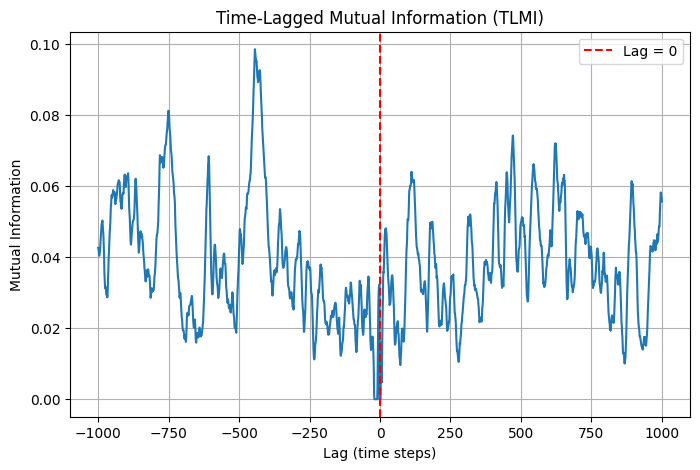

In [331]:
# Compute Time-Lagged Mutual Information
lags_p_td, mi_lagged_p_td = time_lagged_mutual_information(s_p_td,s_c_td, max_lag=1000, num_bins=200)
# Plot Time-Lagged MI
plt.figure(figsize=(8, 5))
#plt.plot(lags, mi_lagged, marker='o')
plt.plot(lags_p_td, mi_lagged_p_td)
#plt.ylim(0.59,0.7)
plt.xlabel("Lag (time steps)")
plt.ylabel("Mutual Information")
plt.title("Time-Lagged Mutual Information (TLMI)")
plt.axvline(0, color='red', linestyle='--', label="Lag = 0")
plt.savefig(pathsave+'/'+'TLMI_td_pitch_counter_'+folders_td[0],bbox_inches='tight')
plt.legend()
plt.grid()
plt.show()

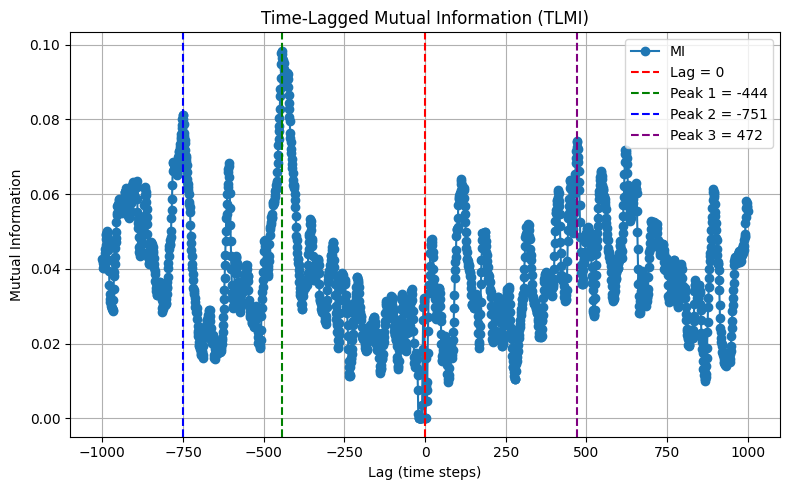

mean_mi: 0.039
std_mi: 0.017
peak_1_mi: 0.098
peak_1_lag: -444
peak_1_leader: Child leads
peak_2_mi: 0.081
peak_2_lag: -751
peak_2_leader: Child leads
peak_3_mi: 0.074
peak_3_lag: 472
peak_3_leader: Mother leads
n_local_peaks: 35.000


In [332]:
stats_tlmi_p_td = summarize_tlmi(lags_p_td, mi_lagged_p_td)

for k, v in stats_tlmi_p_td.items():
    print(f"{k}: {v:.3f}" if isinstance(v, (int, float, np.floating)) else f"{k}: {v}")

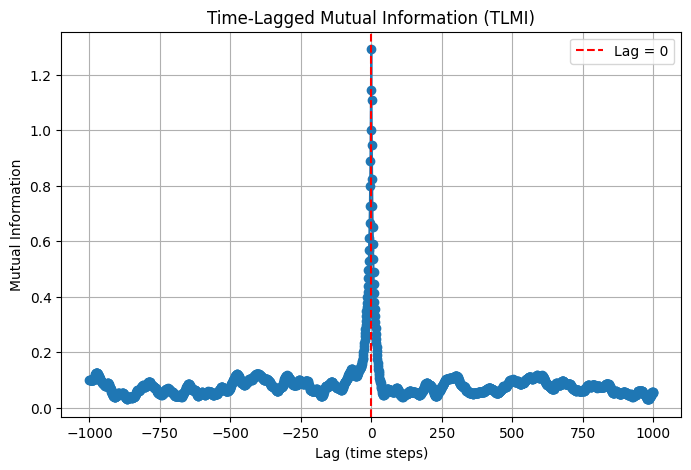

In [333]:
lags_p_asd, mi_lagged_p_asd = time_lagged_mutual_information(s_p_asd,s_c_asd, max_lag=1000, num_bins=200)
# Plot Time-Lagged MI
plt.figure(figsize=(8, 5))
plt.plot(lags_p_asd, mi_lagged_p_asd, marker='o')
#plt.ylim(0.59,0.7)
plt.xlabel("Lag (time steps)")
plt.ylabel("Mutual Information")
plt.title("Time-Lagged Mutual Information (TLMI)")
plt.axvline(0, color='red', linestyle='--', label="Lag = 0")
plt.savefig(pathsave+'/'+'TLMI_asd_pitch_counter_'+folders_asd[0],bbox_inches='tight')
plt.legend()
plt.grid()
plt.show()

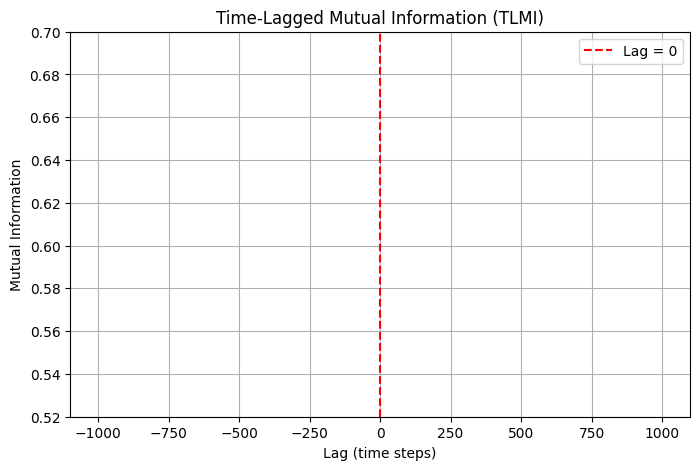

In [334]:
# Compute Time-Lagged Mutual Information
lags_p_td_e, mi_lagged_p_td_e = time_lagged_mutual_information(s_p_td_e,s_c_td_e, max_lag=1000, num_bins=200)
# Plot Time-Lagged MI


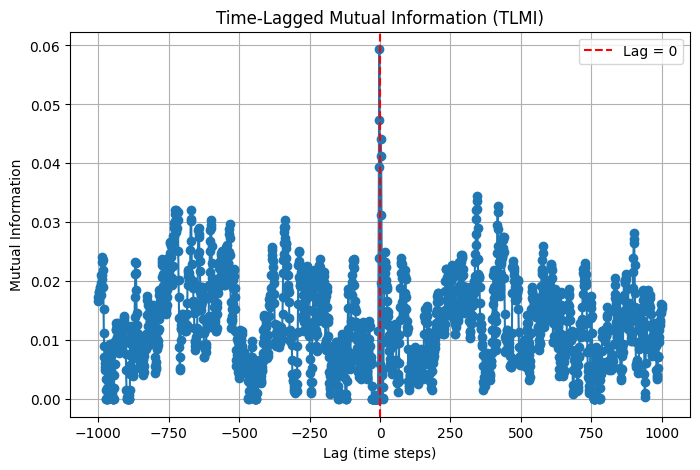

In [338]:
plt.figure(figsize=(8, 5))
plt.plot(lags_p_td_e, mi_lagged_p_td_e, marker='o')
#plt.ylim(0.52,0.7)
plt.xlabel("Lag (time steps)")
plt.ylabel("Mutual Information")
plt.title("Time-Lagged Mutual Information (TLMI)")
plt.axvline(0, color='red', linestyle='--', label="Lag = 0")
plt.savefig(pathsave+'/'+'TLMI_td_energy_counter_'+folders_td[0],bbox_inches='tight')
plt.legend()
plt.grid()
plt.show()

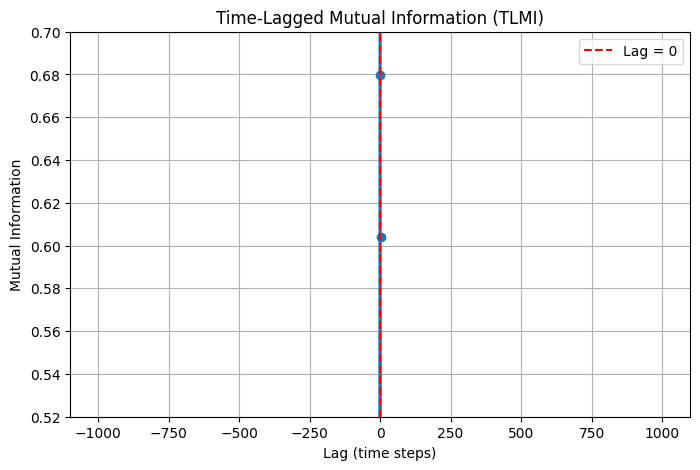

In [335]:
# Compute Time-Lagged Mutual Information
lags_p_asd_e, mi_lagged_p_asd_e = time_lagged_mutual_information(s_p_asd_e,s_c_asd_e, max_lag=1000, num_bins=200)
# Plot Time-Lagged MI


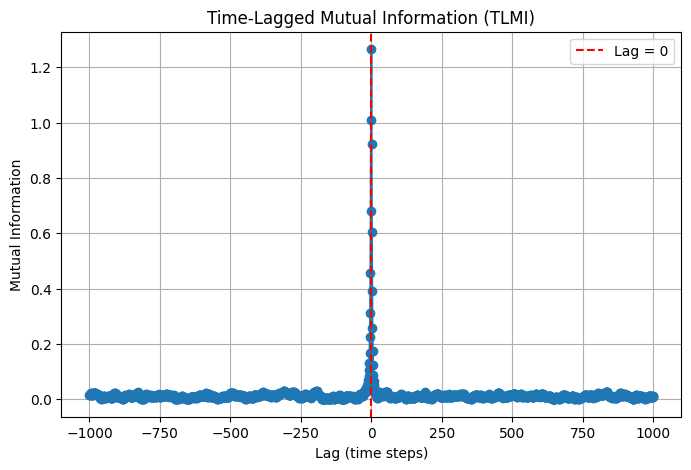

In [337]:
plt.figure(figsize=(8, 5))
plt.plot(lags_p_asd_e, mi_lagged_p_asd_e, marker='o')
#plt.ylim(0.52,0.7)
plt.xlabel("Lag (time steps)")
plt.ylabel("Mutual Information")
plt.title("Time-Lagged Mutual Information (TLMI)")
plt.axvline(0, color='red', linestyle='--', label="Lag = 0")
plt.savefig(pathsave+'/'+'TLMI_asd_energy_counter_'+folders_asd[0],bbox_inches='tight')
plt.legend()
plt.grid()
plt.show()